In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 150)
pd.set_option("display.max_rows", 100)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    make_scorer,
    f1_score,
)

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import LeaveOneOutEncoder
from sklearn.svm import SVC


import statsmodels.api as sm

# from scipy.stats.mstats import winsorize

<IPython.core.display.Javascript object>

In [3]:
import statsmodels.formula.api as smf


import warnings
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
happiness = pd.io.stata.read_stata(
    "/Users/jamesmoss/Downloads/Happiness_Data/Happiness.dta"
)
happiness_object = pd.io.stata.read_stata(
    "/Users/jamesmoss/Downloads/Happiness_Data/Happiness.dta", iterator=True
)
labels = happiness_object.variable_labels()

output_gap_path = "/Users/jamesmoss/Downloads/fredgraph.csv"
output_gap = pd.read_csv(output_gap_path)

<IPython.core.display.Javascript object>

## Data Cleaning/Initial Exploration:

In [5]:
labels

{'intwkenm': 'Minutes of internet use on weekends',
 'satfam': 'Family life',
 'weekswrk': 'Weeks r. worked last year',
 'partfull': "Was r's work part-time or full-time?",
 'satjob': 'Job or housework',
 'class_': 'Subjective class identification',
 'satfin': 'Satisfaction with financial situation',
 'finalter': 'Change in financial situation',
 'finrela': 'Opinion of family income',
 'satcity': 'City or place r lives in',
 'life': 'Is life exciting or dull',
 'partyid': 'Political party affiliation',
 'polviews': 'Think of self as liberal or conservative',
 'equal6': 'One is able to live well in america',
 'relig': 'Rs religious preference',
 'attend': 'How often r attends religious services',
 'happy': 'General happiness',
 'hapmar': 'Happiness of marriage',
 'health': 'Condition of health',
 'fear': 'Afraid to walk at night in neighborhood',
 'tvhours': 'Hours per day watching tv',
 'prestg105plus': 'Rs occupational prestige score using threshold method (2010)',
 'sppres10': 'Spous

<IPython.core.display.Javascript object>

**Missing values:**

In [6]:
happiness_missing = happiness.replace("Not applicable", np.nan)
happiness_missing = happiness_missing.replace("No answer", np.nan)
happiness_missing = happiness_missing.replace("Don't know", np.nan)
happiness_missing = happiness_missing.replace("Dk,na", np.nan)
happiness_missing = happiness_missing.replace("Uncodeable", np.nan)
happiness_missing = happiness_missing.replace("Dk na", np.nan)

happiness_missing = happiness_missing.replace("Eight or more", 8)
happiness_missing = happiness_missing.replace("89 or older", 89)

# (happiness_missing.isna().sum() / len(happiness_missing)).sort_values().head(100)

<IPython.core.display.Javascript object>

**Lists of columns**

In [7]:
happiness_missing.shape

(64814, 80)

<IPython.core.display.Javascript object>

In [8]:
# columns that are duplicated by other information
duplicate_cols = [
    "papres80",
    "mapres80",
    "papres16",
    "sppres80",
    "sppres",
    'sppres10',
    "prestg80",
    "prestige",
    "rincome",
    "income",
    'realinc',
    'realrinc'
]
# columns that have over 80% missing values. Come back to these since most of these
# missing values could be from older surveys
many_missing_cols = [
    "intwkdyh",
    "intwkenm",
    "hrs2",
    "voednme1",
    "height",
    "major1",
    "martype",
    "mntlhlth",
    "equal6",
]

# columns that are missing a lot of recent data.
recent_missing_cols = ["satfam", "satcity"]
older_missing_cols = ["partfull", "ballot", "widowed", "dwelling"]  # ,'weekswrk']
not_useful_cols = [
    "sphrs2",
    "weekswrk",
    'dateintv',
]
numeric_cols = [
    "tvhours",
    "prestg105plus",
    "sppres105plus",
    "papres105plus",
    "mapres105plus",
    "coninc",
    "conrinc",
    "size",
    "hrs1",
    "hompop",
    "childs",
    "age",
    "educ",
    "paeduc",
    "maeduc",
    "year",
]
ordinal_cols = [
    "satjob",
    "class_",
    "satfin",
    "finalter",
    "finrela",
    "life",
    "attend",
    "happy",
    "hapmar",
    "health",
]
emotional_cols = ["satjob", "satfin", "life", "happy", "hapmar"]
possible_redundant_cols = ["xnorcsiz", "papres10", "mapres10", "prestg10"]
somewhat_redundant_cols = ["wrkstat", "hrs1"]
too_many_cats = ["occ10", "spocc10", "spind10", "indus10"]
#if have time, go through indus10 and separate into industry vs service

# drop columns unuseful to the analysis
happiness_skinny = happiness_missing.drop(
    columns=duplicate_cols
    + possible_redundant_cols
    + many_missing_cols
    + not_useful_cols
    + recent_missing_cols
    + too_many_cats
)

#Want to create a second dataframe, happiness_value_labels, so that I can show plot with labels
happiness_value_labels = happiness_skinny.copy() 
for col in numeric_cols:
    happiness_value_labels[col] = happiness_value_labels[col].astype(float)
    happiness_skinny[col] = happiness_skinny[col].astype(float)


for col in ordinal_cols:
    happiness_value_labels[col] = happiness_value_labels[col].astype(str)
    happiness_skinny[col] = happiness_skinny[col].cat.codes
    
for col in happiness_skinny.select_dtypes(include="category"):
    happiness_value_labels[col] = happiness_value_labels[col].astype(str)
    happiness_skinny[col] = happiness_skinny[col].astype(str)
    
happiness_skinny = happiness_skinny.replace("nan", np.nan)
happiness_skinny=happiness_skinny.replace(-1,np.nan)
happiness_skinny=happiness_skinny.replace('-1',np.nan)

happiness_value_labels = happiness_value_labels.replace("nan", np.nan)
happiness_value_labels=happiness_value_labels.replace(-1,np.nan)
happiness_value_labels=happiness_value_labels.replace('-1',np.nan)


happiness_skinny["ballot"] = happiness_skinny.fillna("No Ballot")
happiness_value_labels["ballot"] = happiness_value_labels.fillna("No Ballot")

#drop years with few happiness answers
happiness_skinny = happiness_skinny[happiness_skinny['year'] >1977] 
happiness_value_labels = happiness_value_labels[happiness_value_labels['year'] >1977] 

#drop incomes below 600 (like Kahneman)
happiness_skinny = happiness_skinny[happiness_skinny['conrinc'] >600] 
happiness_value_labels = happiness_value_labels[happiness_value_labels['conrinc'] >600] 
happiness_skinny = happiness_skinny[happiness_skinny['coninc'] >600] 
happiness_value_labels = happiness_value_labels[happiness_value_labels['coninc'] >600] 


<IPython.core.display.Javascript object>

**Missing values by year before interpolation:**

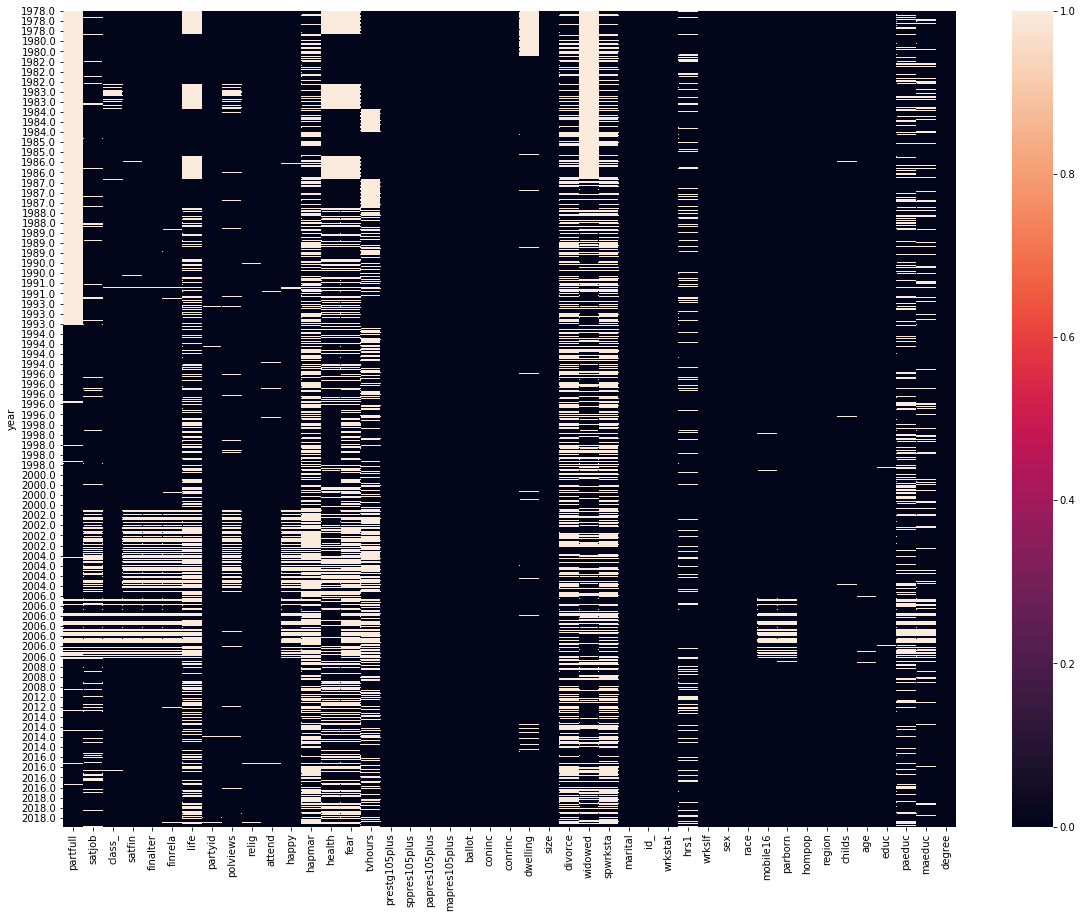

<IPython.core.display.Javascript object>

In [9]:
plt.figure(figsize=(20, 15))
sns.heatmap(pd.isnull(happiness_skinny.set_index(["year"]).sort_index()))
plt.show()

In [10]:
# just forward filling values for each respondent id
# I could possibly linearly interpolate for the ordinal categories, especially happiness
# limit of 3 because that is the number of years between asking the same question
happiness_skinny = (
    happiness_skinny.sort_values(by=["year"])
    .groupby("id_")
    .fillna(method="ffill", limit=3)
    .fillna(method="bfill", limit=3)
    .reset_index()
)

<IPython.core.display.Javascript object>

In [11]:
happiness_value_labels = (
    happiness_value_labels.sort_values(by=["year"])
    .groupby("id_")
    .fillna(method="ffill", limit=3)
    .fillna(method="bfill", limit=3)
    .reset_index()
)


<IPython.core.display.Javascript object>

**Missing values by year after interpolation:**

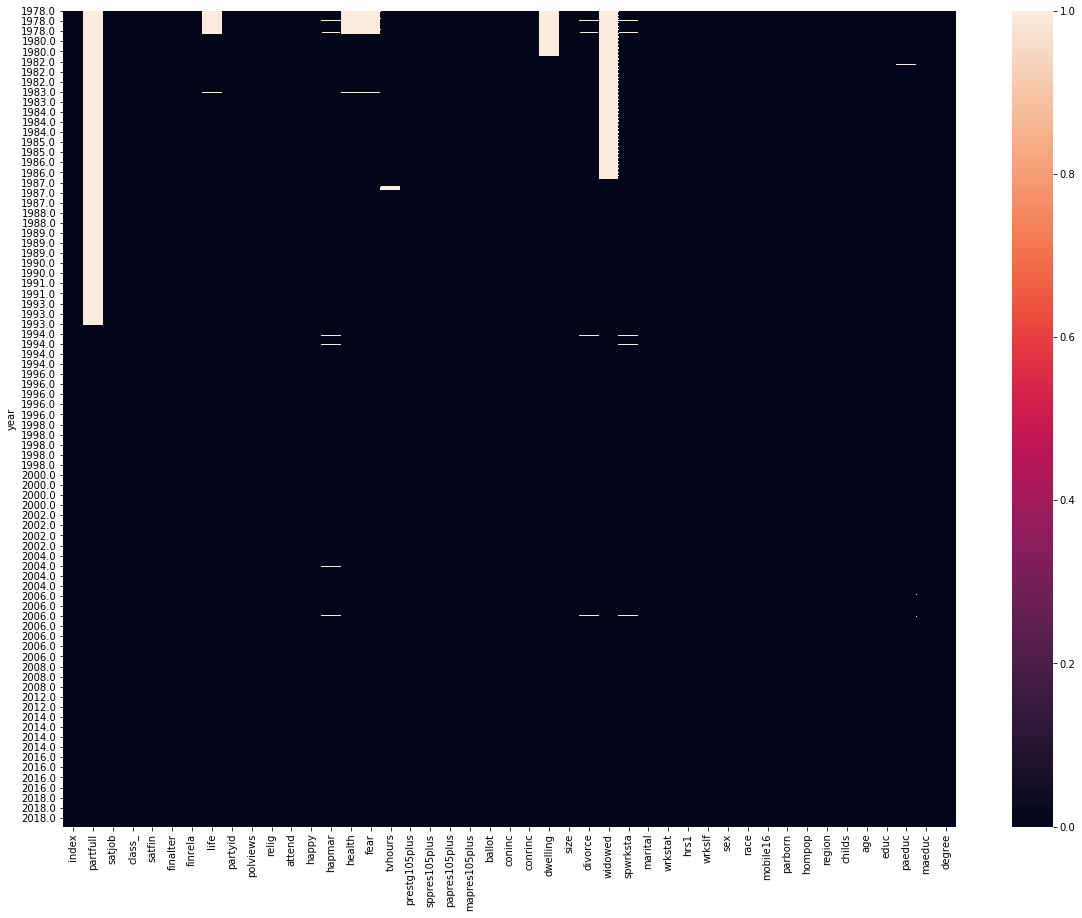

<IPython.core.display.Javascript object>

In [12]:
plt.figure(figsize=(20, 15))
sns.heatmap(pd.isnull(happiness_skinny.set_index(["year"]).sort_index()))
plt.show()

In [13]:
happiness_skinny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32024 entries, 0 to 32023
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          32024 non-null  int64  
 1   partfull       19640 non-null  object 
 2   satjob         31993 non-null  float64
 3   class_         32007 non-null  float64
 4   satfin         32007 non-null  float64
 5   finalter       32007 non-null  float64
 6   finrela        32006 non-null  float64
 7   life           30970 non-null  float64
 8   partyid        32024 non-null  object 
 9   polviews       32024 non-null  object 
 10  relig          32024 non-null  object 
 11  attend         32024 non-null  float64
 12  happy          32007 non-null  float64
 13  hapmar         31723 non-null  float64
 14  health         31048 non-null  float64
 15  fear           30975 non-null  object 
 16  tvhours        31763 non-null  float64
 17  prestg105plus  32024 non-null  float64
 18  sppres

<IPython.core.display.Javascript object>

In [14]:
# missing percentage before:
(happiness_missing.isna().sum() / len(happiness_missing)).sort_values().head(100)

size             0.000000
sppres105plus    0.000000
papres10         0.000000
papres105plus    0.000000
mapres10         0.000000
mapres105plus    0.000000
prestg10         0.000000
xnorcsiz         0.000000
sppres           0.000000
sppres10         0.000000
sppres80         0.000000
prestige         0.000000
prestg80         0.000000
papres16         0.000000
sex              0.000000
race             0.000000
region           0.000000
papres80         0.000000
mapres80         0.000000
id_              0.000000
prestg105plus    0.000000
year             0.000000
hompop           0.000093
wrkstat          0.000324
marital          0.000417
degree           0.002669
educ             0.002731
childs           0.003101
age              0.003518
relig            0.004459
partyid          0.006449
attend           0.009180
mobile16         0.031722
class_           0.053738
wrkslf           0.058568
income           0.069399
satfin           0.071497
dateintv         0.072376
occ10       

<IPython.core.display.Javascript object>

In [15]:
# missing percentage after:
(happiness_skinny.isna().sum() / len(happiness_skinny)).sort_values().head(100)

index            0.000000
mapres105plus    0.000000
ballot           0.000000
degree           0.000000
conrinc          0.000000
size             0.000000
marital          0.000000
wrkstat          0.000000
wrkslf           0.000000
sex              0.000000
race             0.000000
hompop           0.000000
region           0.000000
childs           0.000000
age              0.000000
educ             0.000000
papres105plus    0.000000
sppres105plus    0.000000
coninc           0.000000
partyid          0.000000
prestg105plus    0.000000
polviews         0.000000
relig            0.000000
attend           0.000000
year             0.000000
hrs1             0.000062
happy            0.000531
class_           0.000531
satfin           0.000531
finalter         0.000531
mobile16         0.000531
finrela          0.000562
parborn          0.000562
satjob           0.000968
maeduc           0.001093
paeduc           0.002311
divorce          0.003497
spwrksta         0.005215
tvhours     

<IPython.core.display.Javascript object>

In [16]:
# because research has shown that family death does not particularly affect happiness, I am going to drop
# widow and dwelling should be correlated with income. I might use partfull for a later analysis
# then drop nas
happiness_skinny = happiness_skinny.drop(columns=["widowed", "dwelling"])
happiness_clean = happiness_skinny.drop(columns=["partfull"]).dropna()

happiness_value_labels = happiness_value_labels.drop(columns=["widowed", "dwelling"])
happiness_value_labels_clean = happiness_value_labels.drop(columns=["partfull"]).dropna()


<IPython.core.display.Javascript object>

In [18]:
# happiness_clean.select_dtypes(include="category").nunique()
# happiness_clean.head()

<IPython.core.display.Javascript object>

## Feature Engineering

In [20]:
# age squared
happiness_clean["age_sq"] = happiness_clean["age"] ** 2
happiness_clean["log_fam_income"] = np.log1p(happiness_clean["coninc"])
happiness_clean["log_r_income"] = np.log1p(happiness_clean["conrinc"])
happiness_clean["log_tvhours"] = np.log1p(happiness_clean["tvhours"])
happiness_clean["log_size"] = np.log1p(happiness_clean["size"])


happiness_clean.mapres105plus = happiness_clean.mapres105plus.where(
    happiness_clean.mapres105plus > 0.1, happiness_clean.papres105plus
)

happiness_value_labels_clean["age_sq"] = happiness_clean["age_sq"]
happiness_value_labels_clean["log_fam_income"] = happiness_clean["log_fam_income"]
happiness_value_labels_clean["log_r_income"] = happiness_clean["log_r_income"]
happiness_value_labels_clean["log_tvhours"] = happiness_clean["log_tvhours"]
happiness_value_labels_clean["log_size"] = happiness_clean["log_size"]
happiness_value_labels_clean.mapres105plus = happiness_clean.mapres105plus

# create a median of income each year, then calculate the respondent's income as a fraction of that
happiness_clean["yearly_r_inc_mean"] = happiness_clean.groupby(
    "year"
).conrinc.transform("mean")
happiness_clean["yearly_fam_inc_mean"] = happiness_clean.groupby(
    "year"
).coninc.transform("mean")
happiness_clean["yearly_log_r_income_mean"] = np.log1p(happiness_clean["conrinc"])
happiness_clean["yearly_log_fam_inc_mean"] = np.log1p(happiness_clean["tvhours"])
# happiness_clean['r_inc_difference']=happiness_clean['yearly_r_inc_mean']/happiness_clean['conrinc']
# happiness_clean['r_inc_difference']=happiness_clean['yearly_r_inc_mean']/happiness_clean['conrinc']

# copy them over to the value labels dataset
happiness_value_labels_clean["yearly_r_inc_mean"] = happiness_clean["yearly_r_inc_mean"]
happiness_value_labels_clean["yearly_fam_inc_mean"] = happiness_clean[
    "yearly_fam_inc_mean"
]
happiness_value_labels_clean["yearly_log_r_income_mean"] = happiness_clean[
    "yearly_log_r_income_mean"
]
happiness_value_labels_clean["yearly_log_fam_inc_mean"] = happiness_clean[
    "yearly_log_fam_inc_mean"
]


# create an inverse of 'happy', so that 3 is very happy, 2 is pretty happy, and 1 is not too happy
happiness_clean["happy_inv"] = 3 - happiness_clean["happy"]

# create binary happiness variables
happiness_clean["happy_very_bin"] = (happiness_clean["happy_inv"] == 3).astype(int)
happiness_clean["happy_pretty_bin"] = (happiness_clean["happy_inv"] > 1).astype(int)
numeric_cols = numeric_cols + [
    "age_sq",
    "log_fam_income",
    "log_r_income",
    "log_tvhours",
    "log_size",
    "yearly_r_inc_mean",
    "yearly_fam_inc_mean",
    "yearly_log_r_income_mean",
    "yearly_log_fam_inc_mean",
]
# Create binary/dummies for other variables:
happiness_clean["marital_bin"] = (happiness_clean["marital"] == "Married").astype(int)
happiness_clean["divorce_bin"] = (happiness_clean["divorce"] == "Yes").astype(int)
happiness_clean["fear_bin"] = (happiness_clean["fear"] == "Yes").astype(int)
happiness_clean["relig_bin"] = 1 - (happiness_clean["relig"] == "None").astype(int)
# pd.get_dummies for race
happiness_clean = pd.concat(
    [
        happiness_clean,
        pd.get_dummies(happiness_clean.race, prefix="race", drop_first=False),
    ],
    axis=1,
)
happiness_clean = happiness_clean.drop(columns=["race_Other"])


all_cat_cols = happiness_value_labels_clean.select_dtypes(include="object").columns
non_ordinal_cat_cols = happiness_clean.select_dtypes(include="object").columns

<IPython.core.display.Javascript object>

In [21]:
# preparing the output gap dataset to merge with the happiness dataset:
output_gap["year"] = pd.to_datetime(output_gap["DATE"]).dt.year
output_gap_year = output_gap.drop(columns=["DATE"])
# output gap is percent output gap
# meaning percent difference between real and potential GDP--> ((PGDP-RGDP)/RGDP*100)
# So a higher number is worse
output_gap_year.head()

,GDPC1_GDPPOT,year
0,-4.055348,1975
1,-1.997311,1976
2,-0.764094,1977
3,1.165605,1978
4,0.815453,1979


<IPython.core.display.Javascript object>

In [22]:
# merging the datasets
happiness_clean = happiness_clean.merge(output_gap_year, how="left", on="year")
happiness_value_labels_clean = happiness_value_labels_clean.merge(output_gap_year, how="left", on="year")
happiness_clean=happiness_clean.rename(columns={'GDPC1_GDPPOT':'output_gap'})
happiness_value_labels_clean=happiness_value_labels_clean.rename(columns={'GDPC1_GDPPOT':'output_gap'})
numeric_cols = numeric_cols + ['output_gap']


<IPython.core.display.Javascript object>

See what our relatively final dataset looks like:

In [23]:
happiness_clean.head()

,index,satjob,class_,satfin,finalter,finrela,life,partyid,polviews,relig,attend,happy,hapmar,health,fear,tvhours,prestg105plus,sppres105plus,papres105plus,mapres105plus,ballot,coninc,conrinc,size,divorce,spwrksta,marital,wrkstat,hrs1,wrkslf,sex,race,mobile16,parborn,hompop,region,childs,age,educ,paeduc,maeduc,degree,year,age_sq,log_fam_income,log_r_income,log_tvhours,log_size,yearly_r_inc_mean,yearly_fam_inc_mean,yearly_log_r_income_mean,yearly_log_fam_inc_mean,happy_inv,happy_very_bin,happy_pretty_bin,marital_bin,divorce_bin,fear_bin,relig_bin,race_Black,race_White,output_gap
0,9598,2.0,1.0,2.0,2.0,1.0,1.0,Not str republican,Moderate,None,0.0,1.0,0.0,3.0,Yes,2.0,19.0,0.0,0.0,0.0,No Ballot,22573.0,22573.0,8.0,Yes,Working fulltime,Widowed,Working fulltime,53.0,Someone else,Female,Black,Different state,Both in u.s,1.0,Pacific,0.0,39.0,12.0,8.0,0.0,High school,1978.0,1521.0,10.024554,10.024554,1.098612,2.197225,22573.000000,22573.000000,10.024554,1.098612,2.0,0,1,0,1,1,0,1,0,1.165605
1,11668,0.0,1.0,1.0,1.0,1.0,1.0,Strong democrat,Moderate,Protestant,2.0,2.0,0.0,3.0,Yes,2.0,23.0,0.0,0.0,0.0,No Ballot,9892.0,9892.0,497.0,Yes,Working fulltime,Widowed,Working parttime,20.0,Self-employed,Male,White,"Same st,dif city",Both in u.s,1.0,South atlantic,2.0,60.0,12.0,8.0,6.0,High school,1980.0,3600.0,9.199583,9.199583,1.098612,6.210600,32329.341463,51693.430894,9.199583,1.098612,1.0,0,0,0,1,1,1,0,1,-1.871650
2,11634,1.0,2.0,0.0,0.0,2.0,1.0,Not str democrat,Moderate,None,1.0,1.0,0.0,0.0,Yes,4.0,59.0,0.0,0.0,0.0,No Ballot,35722.0,35722.0,201.0,Yes,Working fulltime,Never married,Working fulltime,40.0,Someone else,Male,White,Same city,Both in u.s,2.0,W. nor. central,3.0,34.0,12.0,8.0,12.0,High school,1980.0,1156.0,10.483550,10.483550,1.609438,5.308268,32329.341463,51693.430894,10.483550,1.609438,2.0,0,1,0,1,1,0,0,1,-1.871650
3,11635,0.0,2.0,1.0,0.0,3.0,0.0,Strong democrat,Extrmly conservative,Protestant,8.0,1.0,0.0,2.0,No,4.0,29.0,48.0,58.0,58.0,No Ballot,14289.0,9892.0,201.0,Yes,Working fulltime,Married,Retired,40.0,Someone else,Male,White,"Same st,dif city",Both in u.s,2.0,W. nor. central,3.0,56.0,8.0,8.0,8.0,Lt high school,1980.0,3136.0,9.567315,9.199583,1.609438,5.308268,32329.341463,51693.430894,9.199583,1.609438,2.0,0,1,1,1,0,1,0,1,-1.871650
4,11636,0.0,1.0,0.0,0.0,2.0,0.0,Not str democrat,Moderate,Protestant,3.0,0.0,0.0,1.0,No,1.0,29.0,26.0,58.0,58.0,No Ballot,82436.0,82436.0,201.0,No,Keeping house,Married,Temp not working,52.0,Someone else,Male,White,Same city,Both in u.s,2.0,W. nor. central,1.0,58.0,8.0,7.0,8.0,Lt high school,1980.0,3364.0,11.319790,11.319790,0.693147,5.308268,32329.341463,51693.430894,11.319790,0.693147,3.0,1,1,1,0,0,1,0,1,-1.871650


<IPython.core.display.Javascript object>

In [24]:
happiness_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30509 entries, 0 to 30508
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     30509 non-null  int64  
 1   satjob                    30509 non-null  float64
 2   class_                    30509 non-null  float64
 3   satfin                    30509 non-null  float64
 4   finalter                  30509 non-null  float64
 5   finrela                   30509 non-null  float64
 6   life                      30509 non-null  float64
 7   partyid                   30509 non-null  object 
 8   polviews                  30509 non-null  object 
 9   relig                     30509 non-null  object 
 10  attend                    30509 non-null  float64
 11  happy                     30509 non-null  float64
 12  hapmar                    30509 non-null  float64
 13  health                    30509 non-null  float64
 14  fear  

<IPython.core.display.Javascript object>

## Univariate Analysis

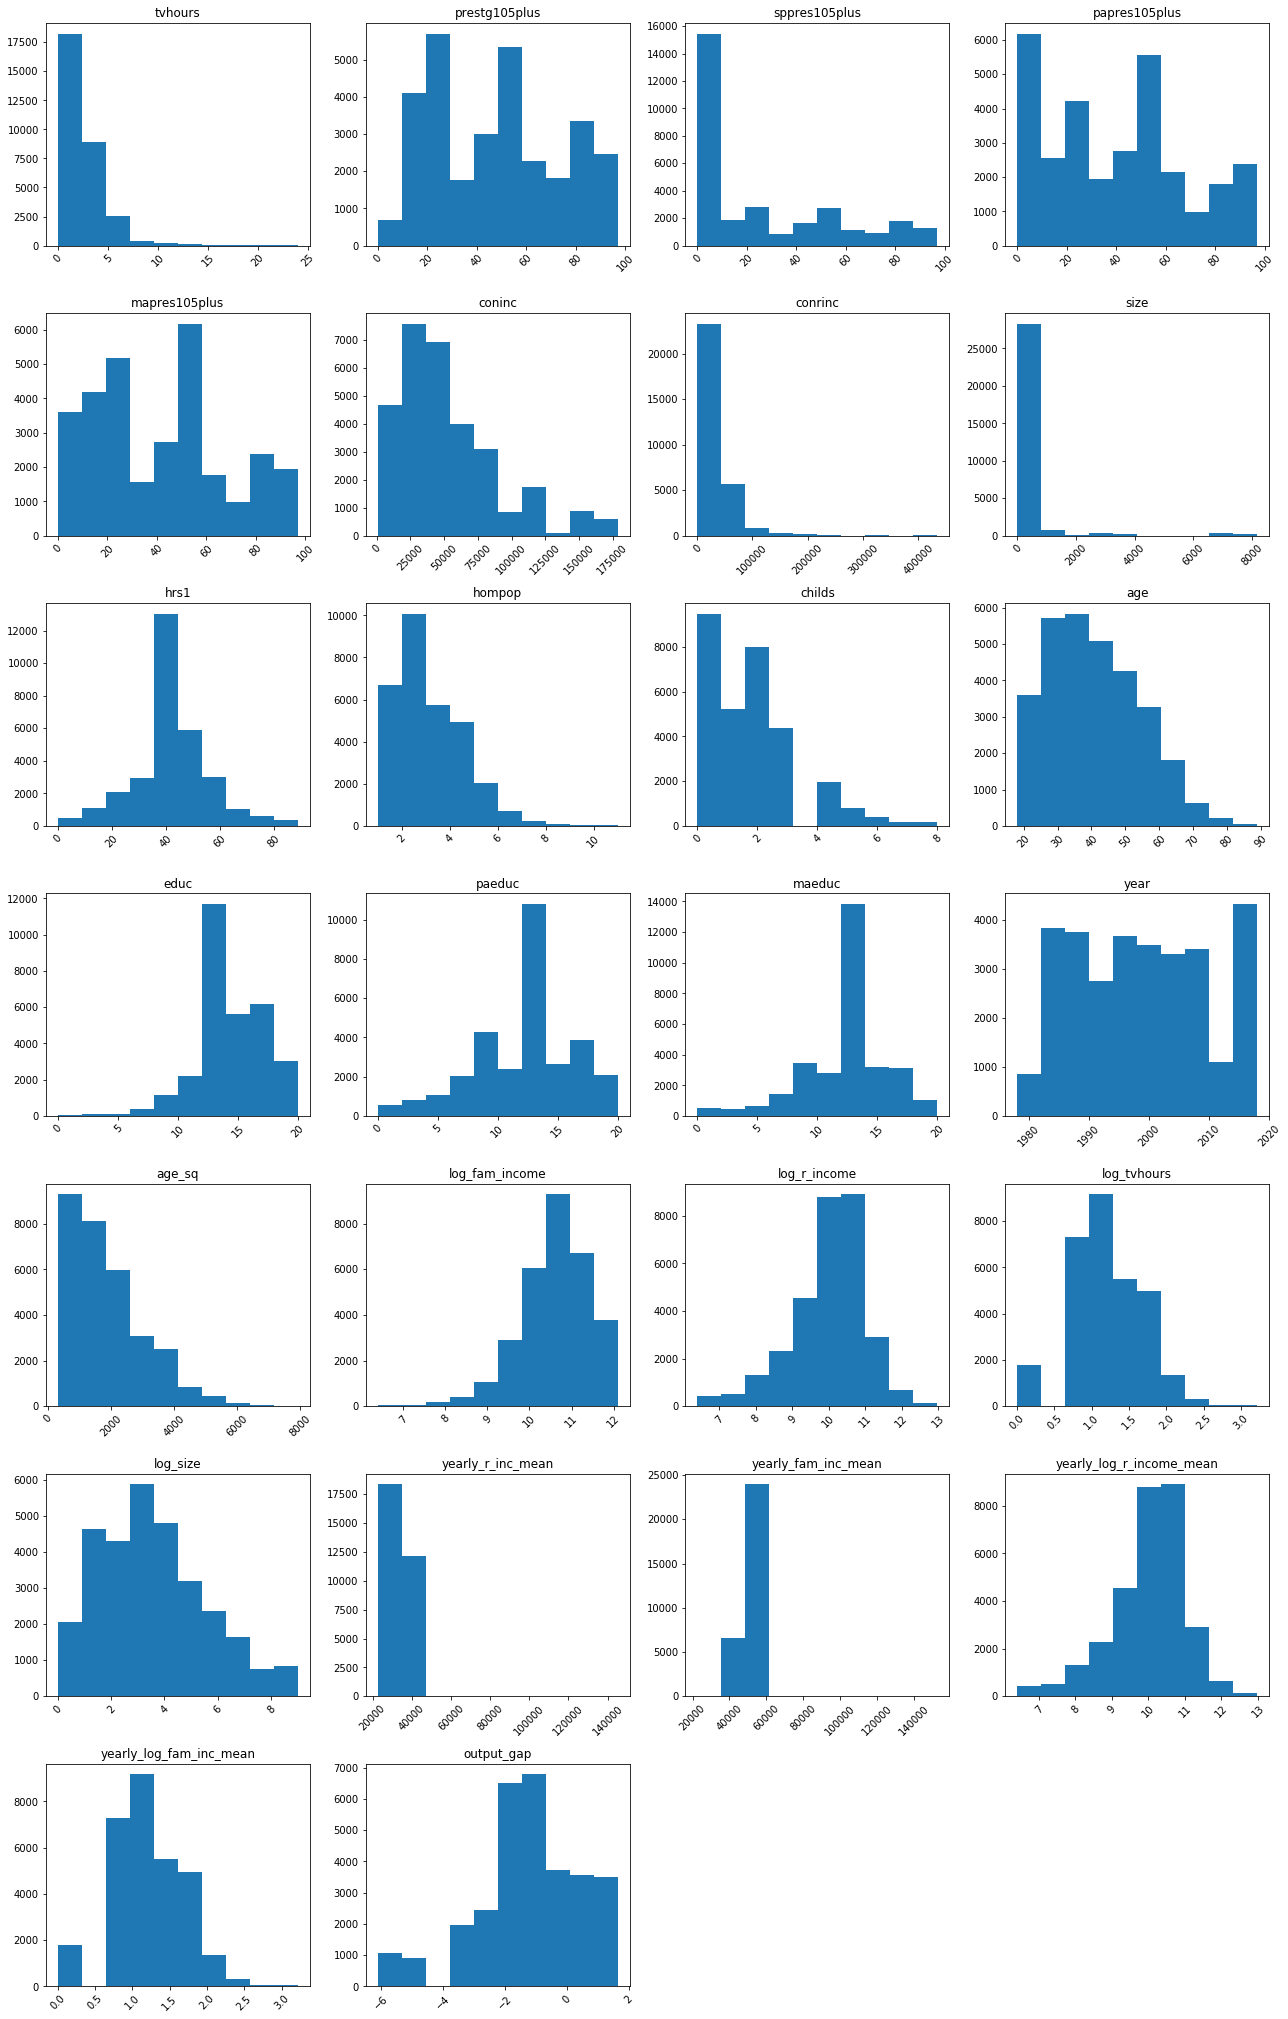

<IPython.core.display.Javascript object>

In [25]:
plt.figure(figsize=(18, 56))
count = 1
for col in numeric_cols:
    plt.subplot(14, 4, count)
    plt.hist(happiness_value_labels_clean[col])
    plt.title(col)
    plt.xticks(rotation=45)
    count = count + 1
plt.tight_layout()
plt.show()

You can see that some variables of interest, namely income and log income, are quite skewed

## Exploration of patterns (correlations and pairwise analysis)

In [26]:
len(numeric_cols)

26

<IPython.core.display.Javascript object>

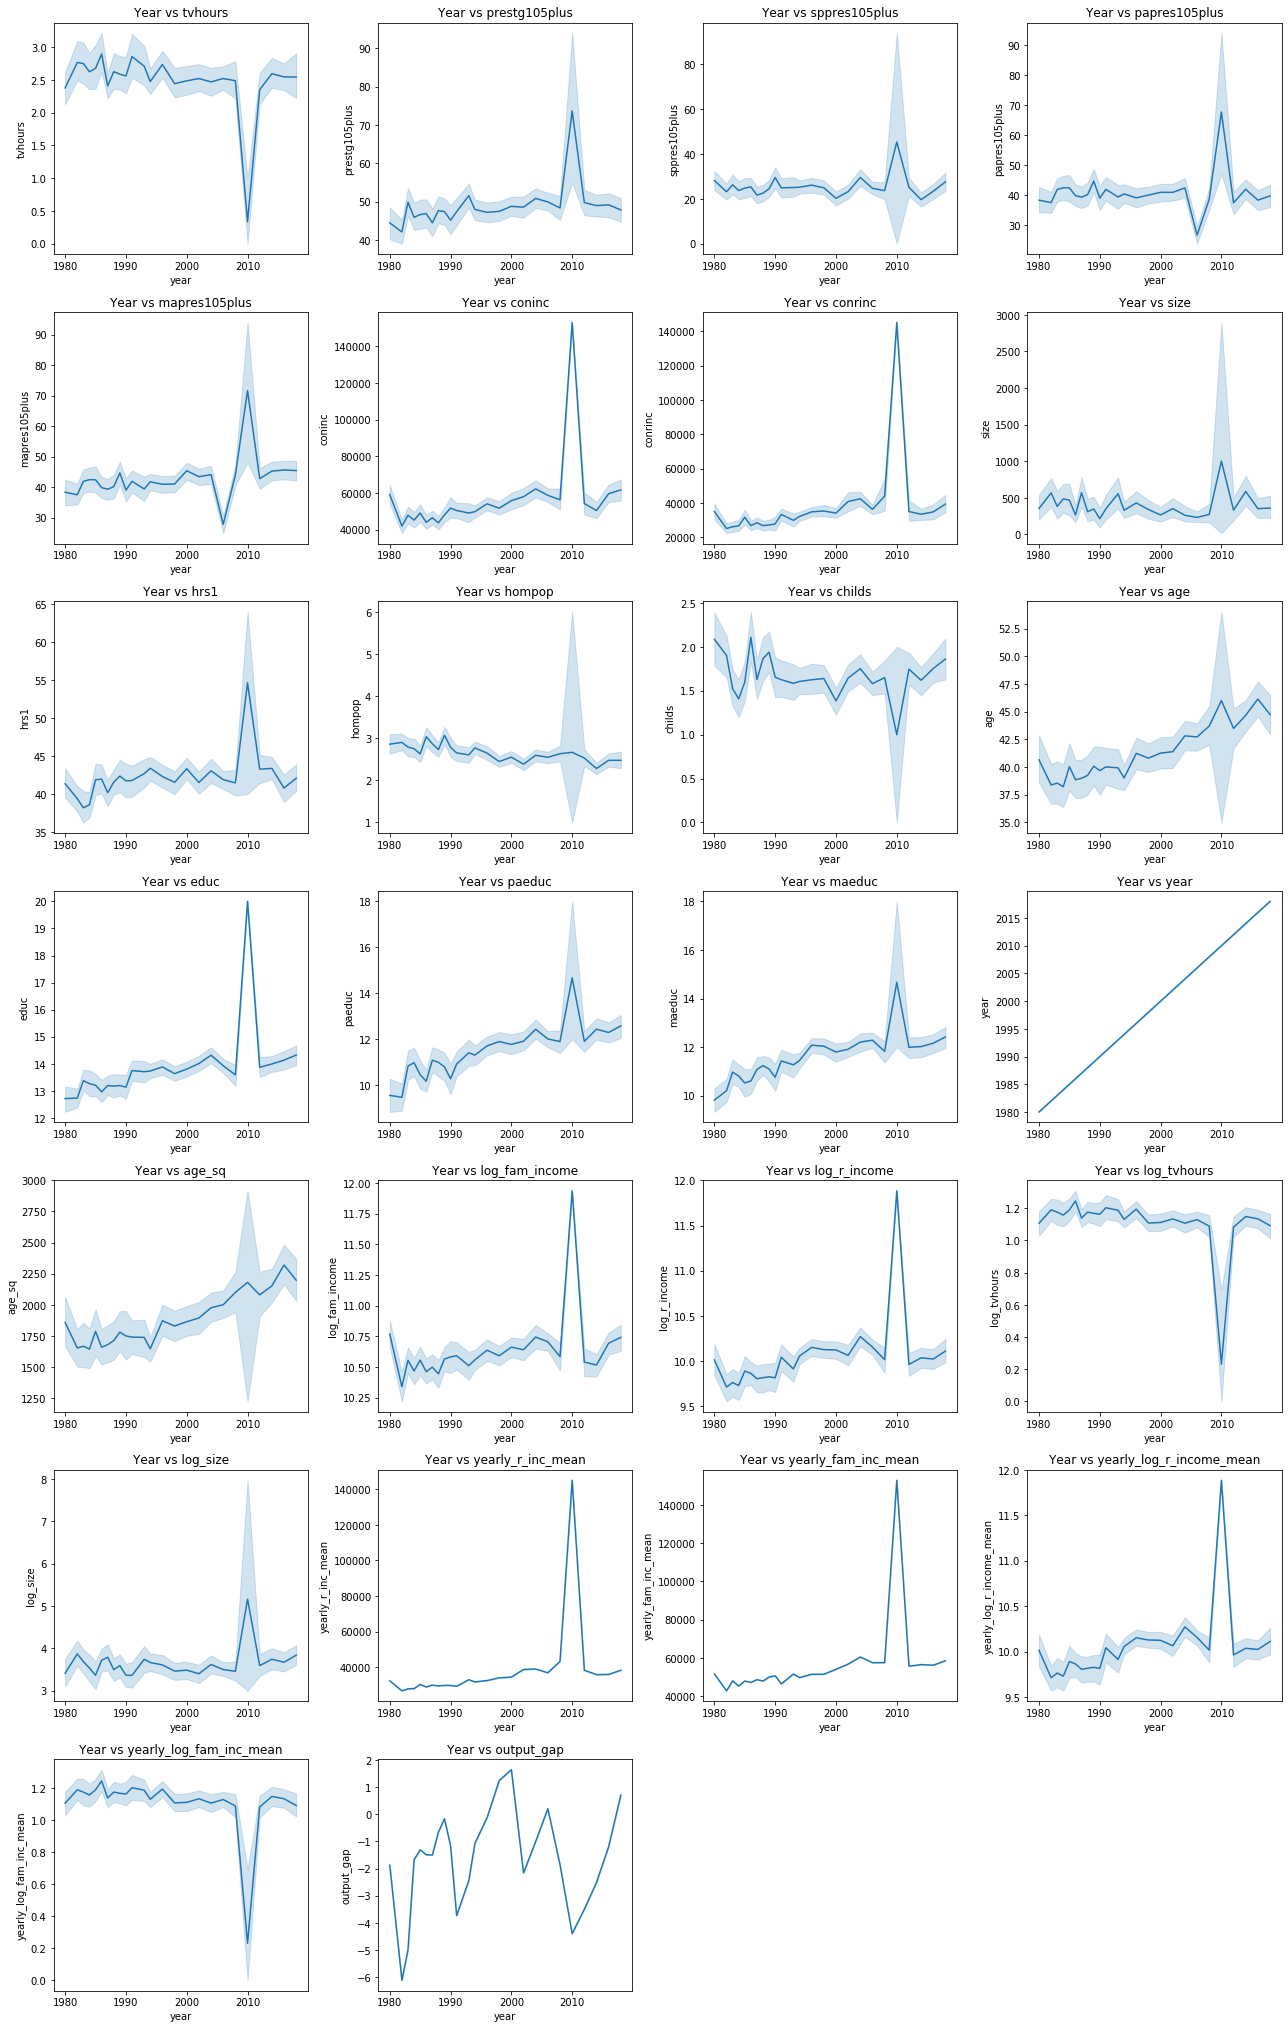

<IPython.core.display.Javascript object>

In [27]:
# Patterns over time
plt.figure(figsize=(18, 56))
count = 1
for col in numeric_cols:
    plt.subplot(14, 4, count)
    sns.lineplot(
        x="year",
        y=col,
        data=happiness_clean.sample(frac=0.2, replace=True, random_state=1),
    )
    plt.title("Year vs " + col)
    count = count + 1
plt.tight_layout()
plt.show()

You can see that, above, the prestiges had a weird dip one year, in which they probably coded a lot of 0s

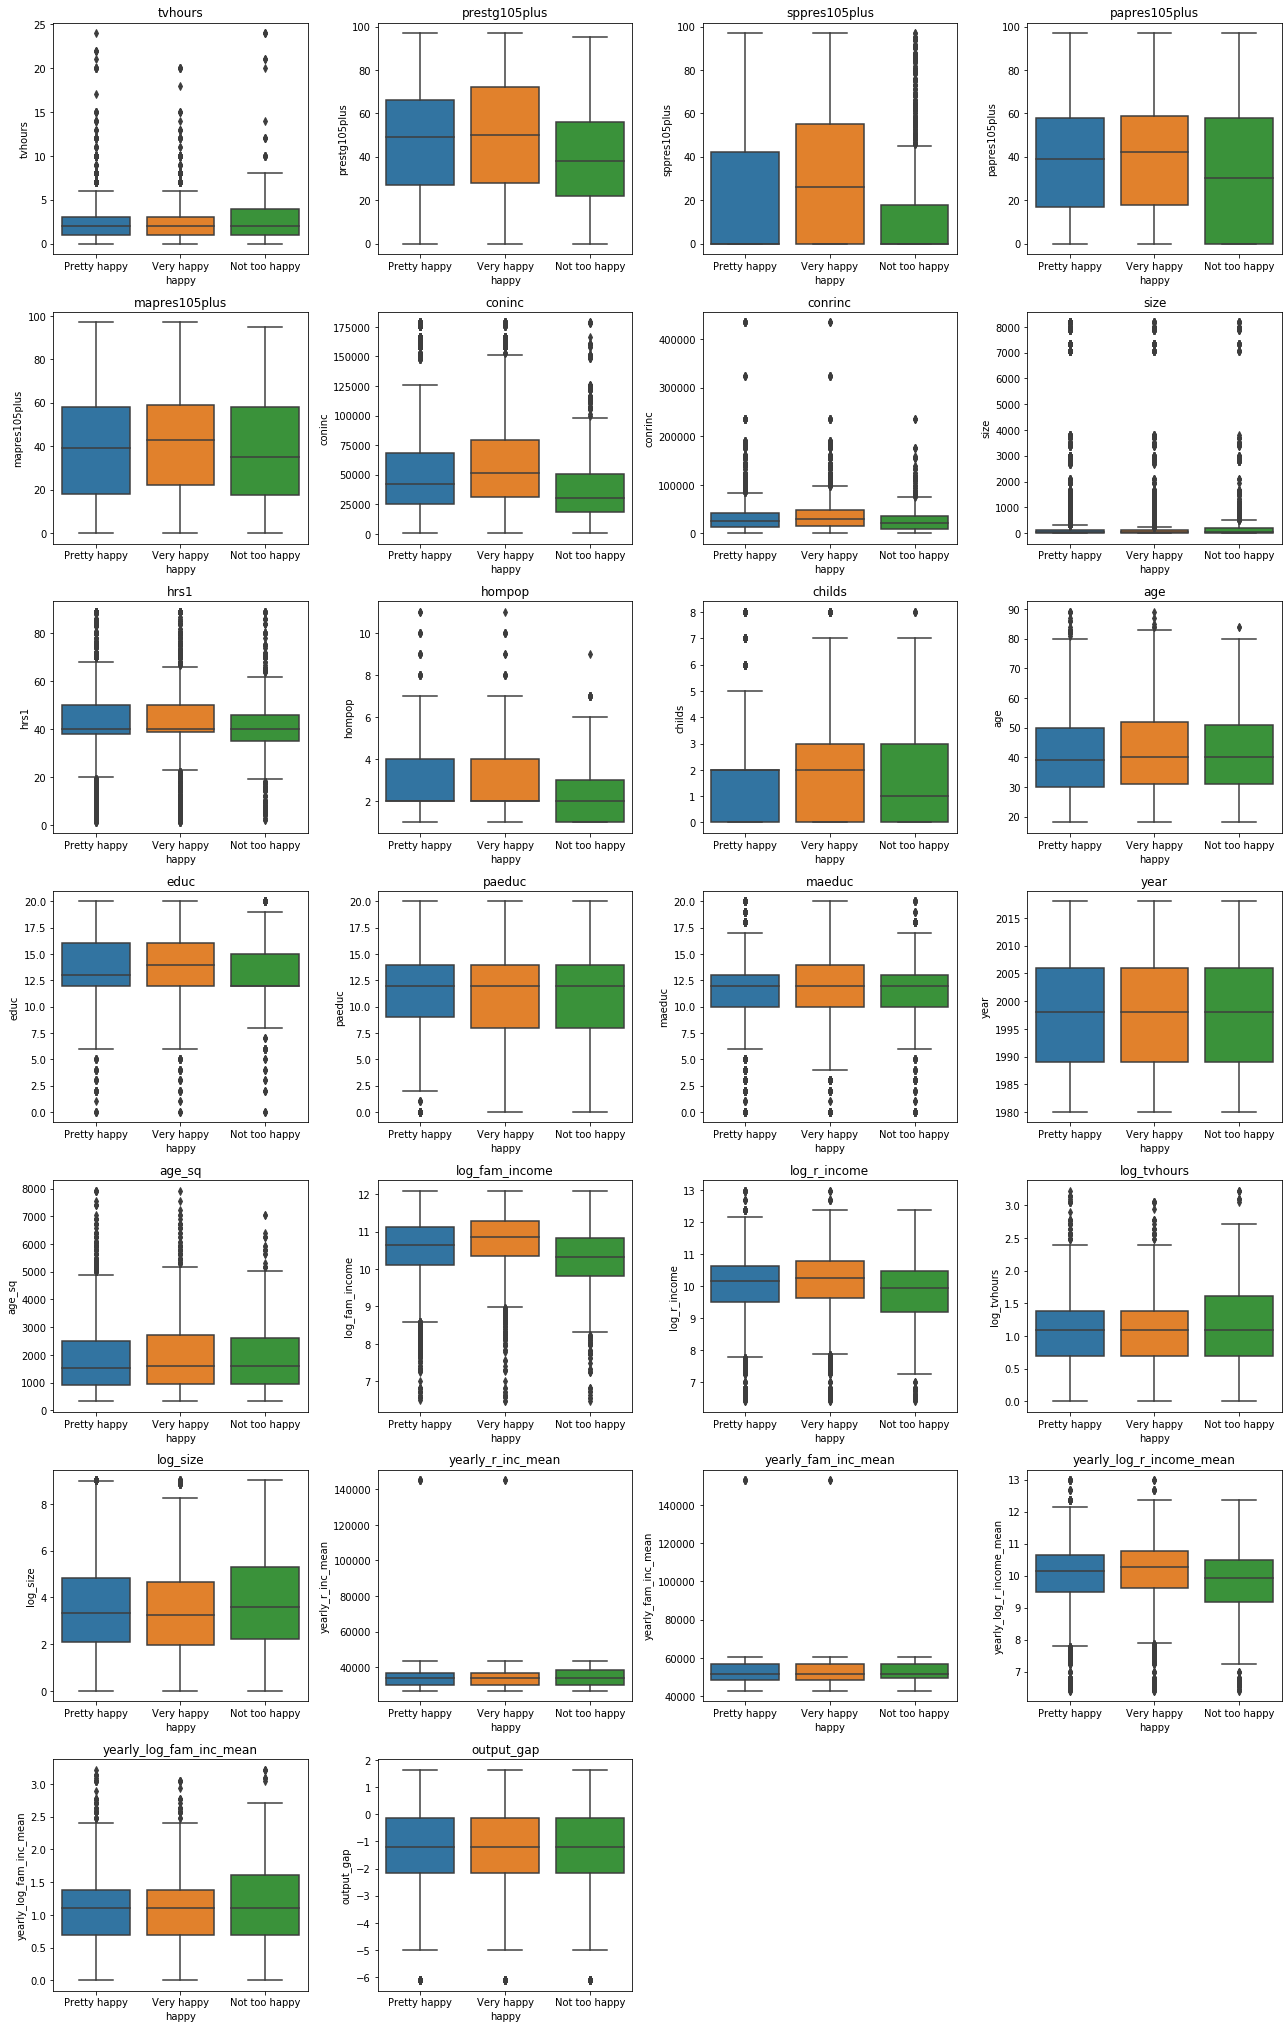

<IPython.core.display.Javascript object>

In [28]:
plt.figure(figsize=(18, 56))
count = 1
for col in numeric_cols:
    plt.subplot(14, 4, count)
    sns.boxplot(
        y=col,
        x="happy",
        data=happiness_value_labels_clean.sample(
            frac=0.5, replace=True, random_state=1
        ),
    )
    plt.title(col)
    count = count + 1
plt.tight_layout()
plt.show()

Looking above, I might want to take the log of size and tvhrs.

You can see how people's happiness does increase with income

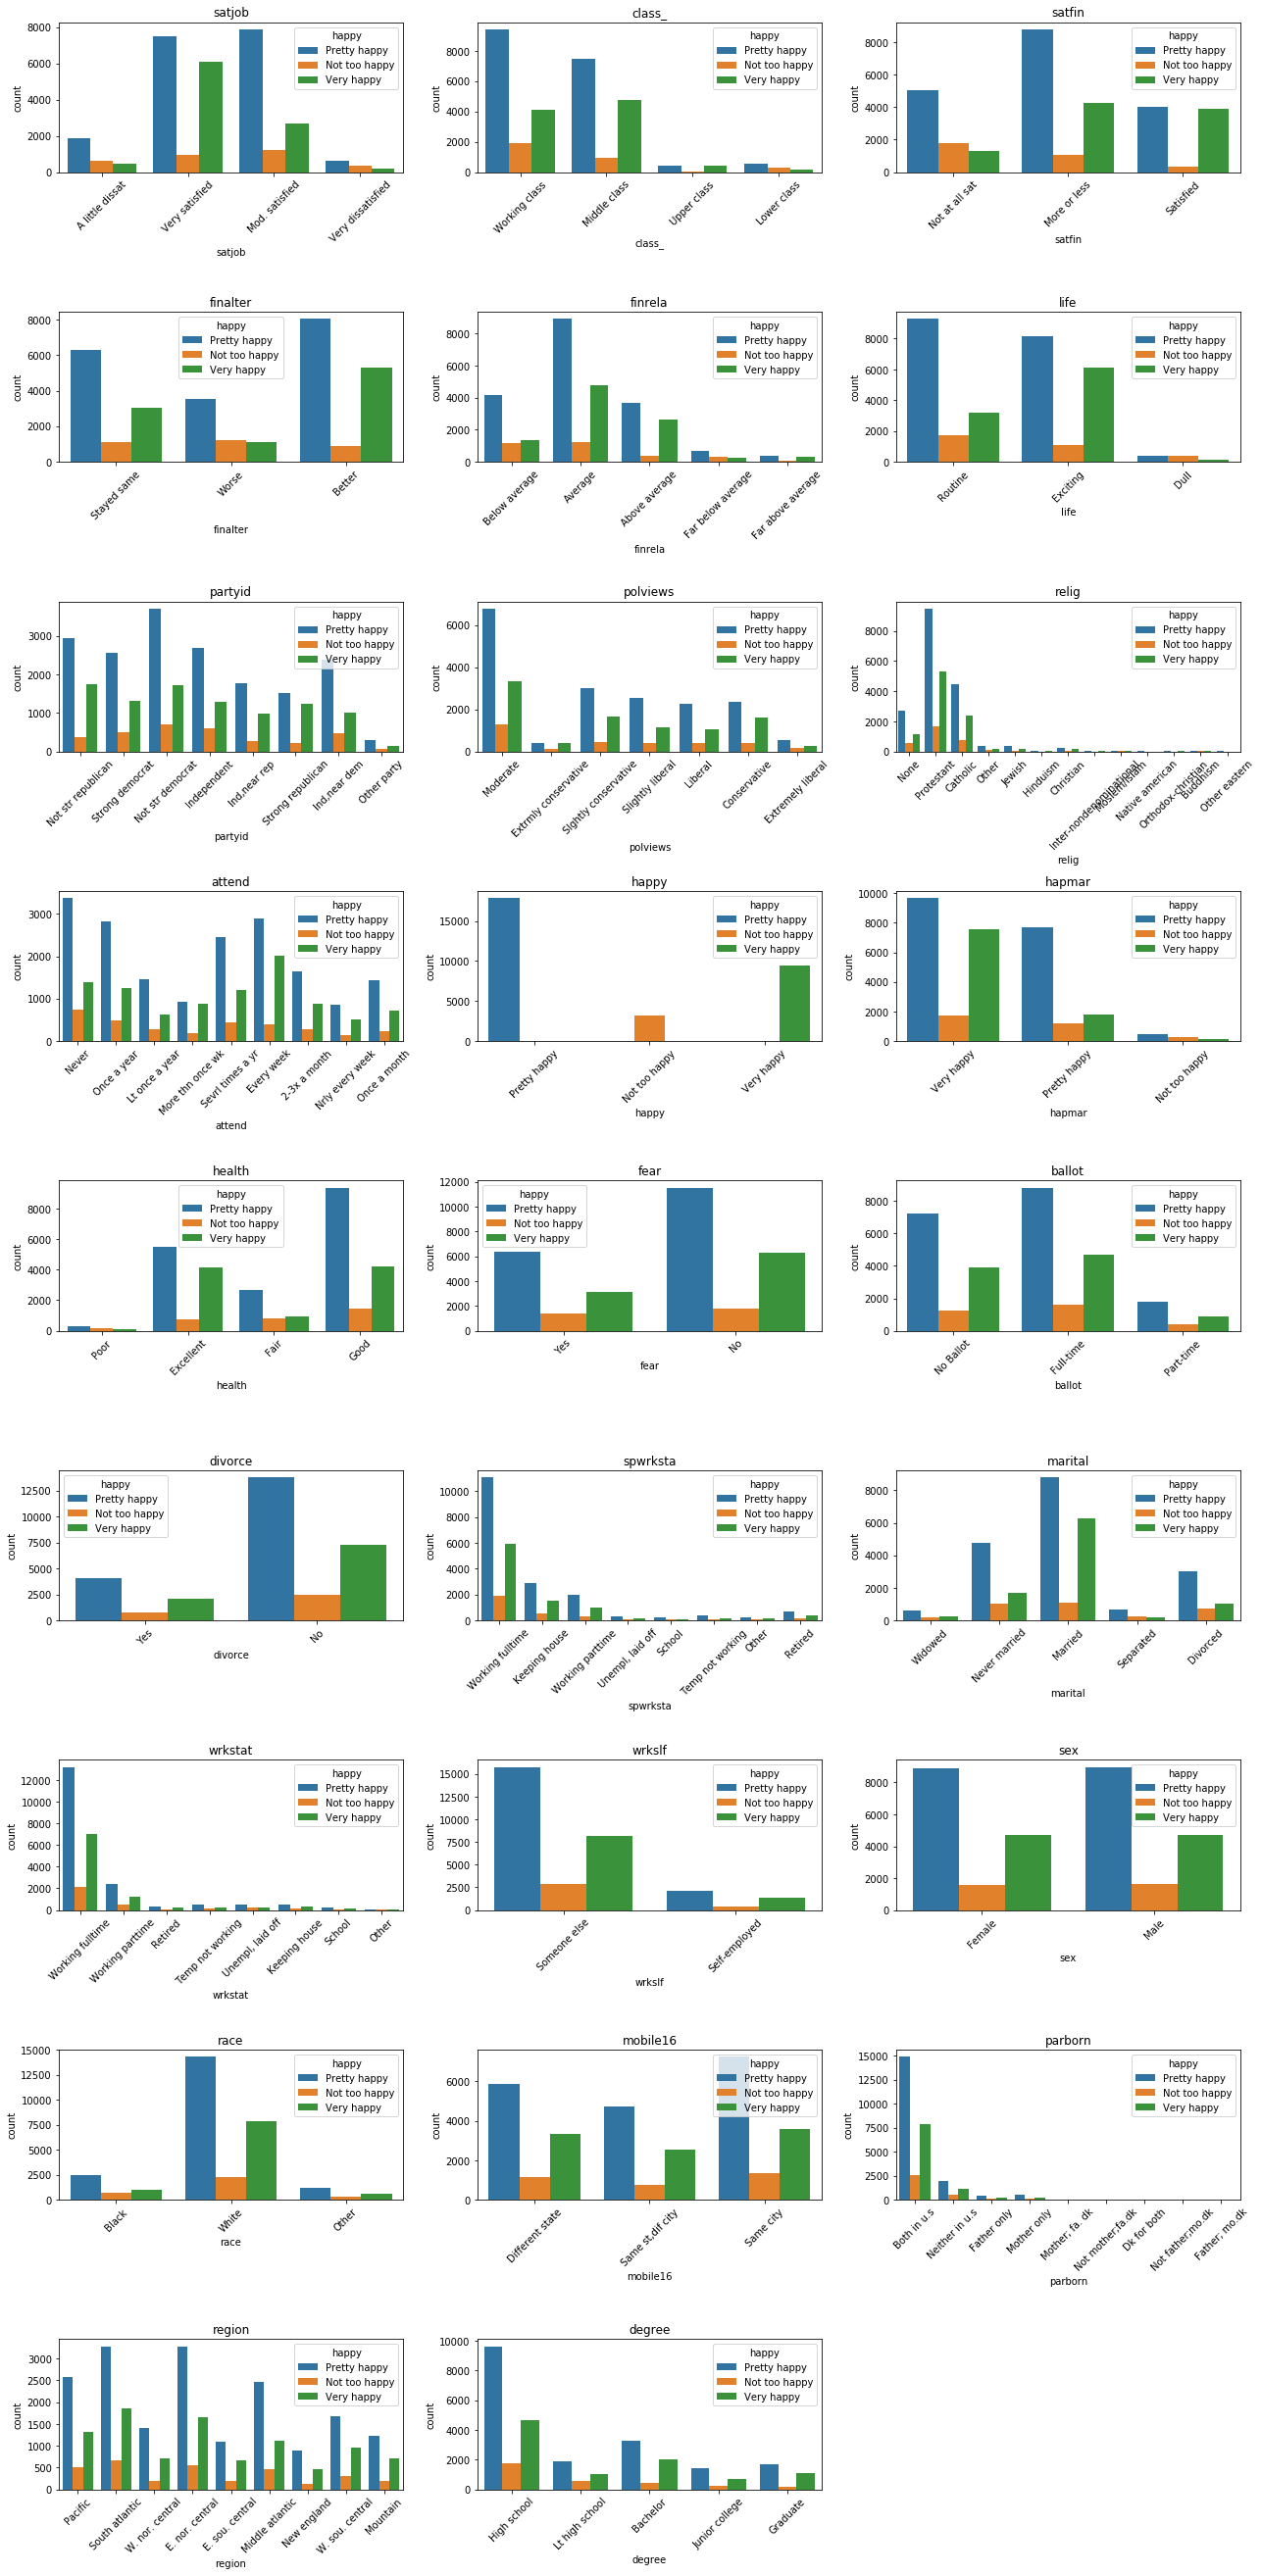

<IPython.core.display.Javascript object>

In [29]:
plt.figure(figsize=(18, 56))
count = 1
for col in all_cat_cols:
    plt.subplot(14, 3, count)
    sns.countplot(x=col, hue="happy", data=happiness_value_labels_clean)
    plt.title(col)
    plt.xticks(rotation=45)
    count = count + 1
plt.tight_layout()
plt.show()

TODO: remove the ones with all the exta cats above

## Exploration of Happiness

In [30]:
year_happiness = pd.crosstab(
    happiness_value_labels_clean.year,
    happiness_value_labels_clean.happy,
    normalize="index",
)
year_happiness[1978:]

happy,Not too happy,Pretty happy,Very happy
year,,,
1978.0,0.000000,1.000000,0.000000
1980.0,0.116144,0.560976,0.322880
1982.0,0.121097,0.586566,0.292337
1983.0,0.115594,0.570338,0.314068
1984.0,0.113910,0.553122,0.332968
1985.0,0.104984,0.612937,0.282078
1986.0,0.090090,0.599099,0.310811
1987.0,0.111220,0.585630,0.303150
1988.0,0.080173,0.588299,0.331528


<IPython.core.display.Javascript object>

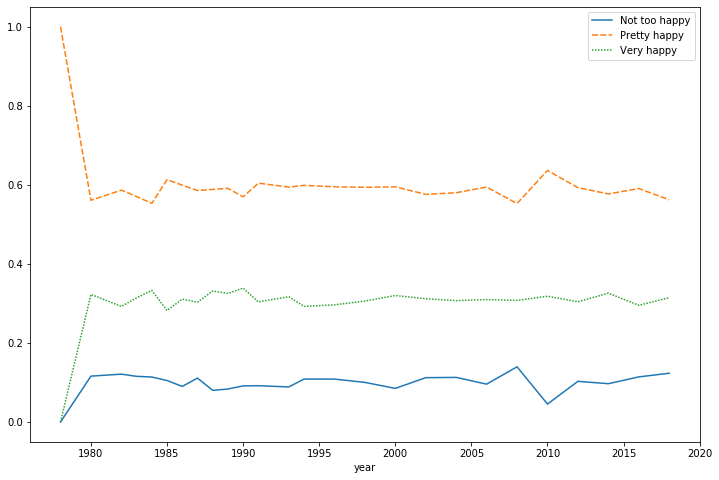

<IPython.core.display.Javascript object>

In [31]:
# we can see that most people are either "pretty happy" or 'Very happy', though you can see a decline in very happy
# and an increase in not too happy
plt.figure(figsize=(12, 8))
sns.lineplot(data=year_happiness[1978:])
plt.show()

In [32]:
happiness_clean["happy"].value_counts()

1.0    17862
0.0     9451
2.0     3196
Name: happy, dtype: int64

<IPython.core.display.Javascript object>

In [33]:
happiness_value_labels_clean.happy.value_counts()

Pretty happy     17862
Very happy        9451
Not too happy     3196
Name: happy, dtype: int64

<IPython.core.display.Javascript object>

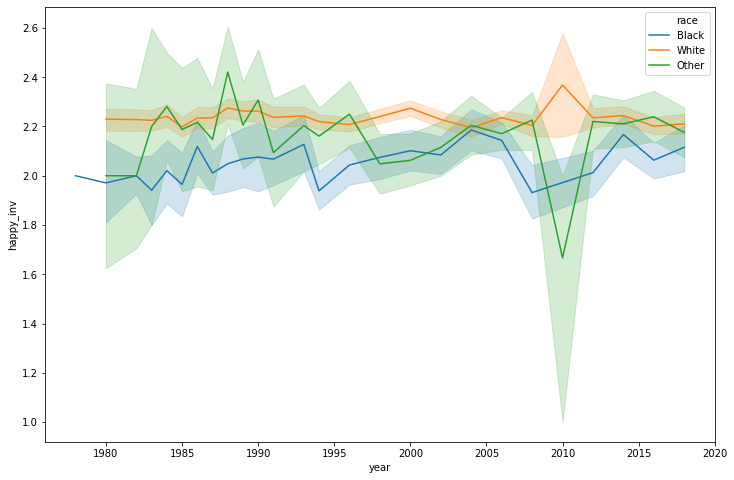

<IPython.core.display.Javascript object>

In [34]:
# the relatively stable overall levels of happiness mask a well-documented decrease in happiness inequality
plt.figure(figsize=(12, 8))
sns.lineplot(data=happiness_clean, x="year", y="happy_inv", hue="race")
plt.show()

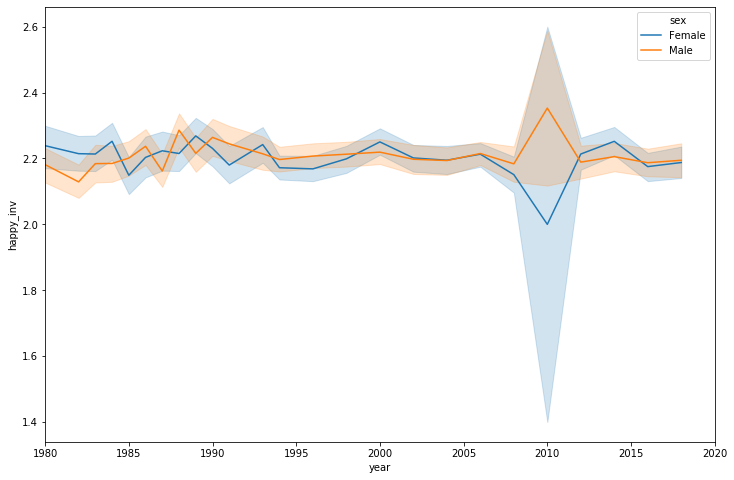

<IPython.core.display.Javascript object>

In [35]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=happiness_clean, x="year", y="happy_inv", hue="sex")
plt.xlim(1980, 2020)
plt.show()

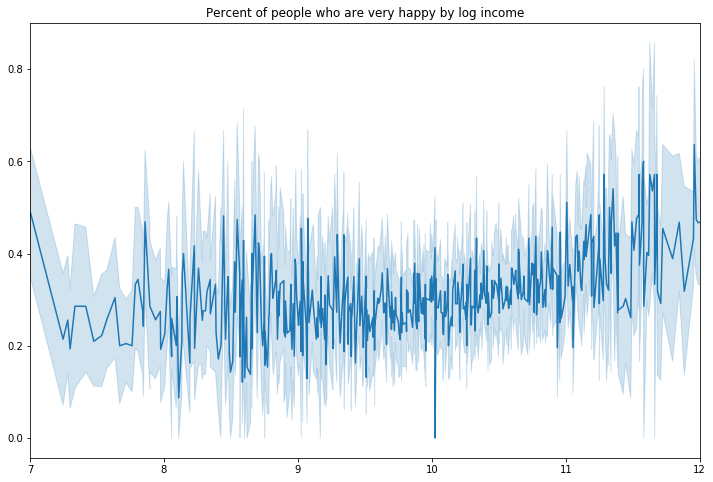

<IPython.core.display.Javascript object>

In [36]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=happiness_clean.set_index("log_r_income")["happy_very_bin"])
plt.title("Percent of people who are very happy by log income")
plt.xlim(7, 12)
plt.show()

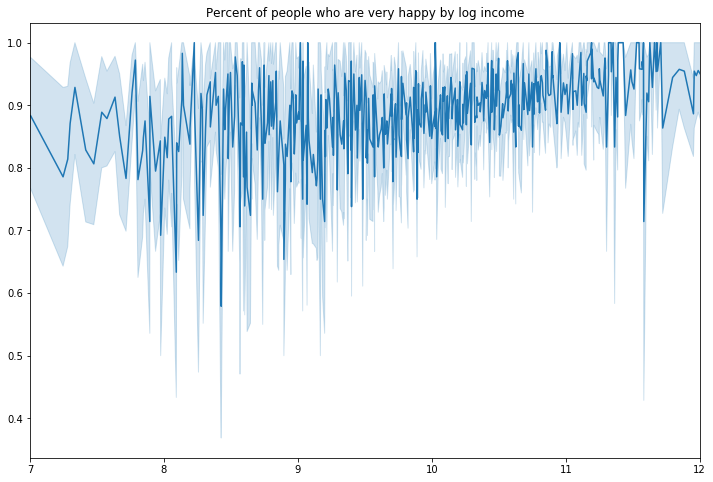

<IPython.core.display.Javascript object>

In [37]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=happiness_clean.set_index("log_r_income")["happy_pretty_bin"])
plt.title("Percent of people who are very happy by log income")
plt.xlim(7, 12)
plt.show()

In [38]:
# TODO: want to do a scatter and color by year here
# plt.figure(figsize=(12, 8))
# sns.scatter(data=happiness_clean, x="log_r_income", y=["happy_pretty_bin"])
# plt.title("Percent of people who are very happy by log income")
# plt.xlim(7, 12)
# plt.show()

<IPython.core.display.Javascript object>

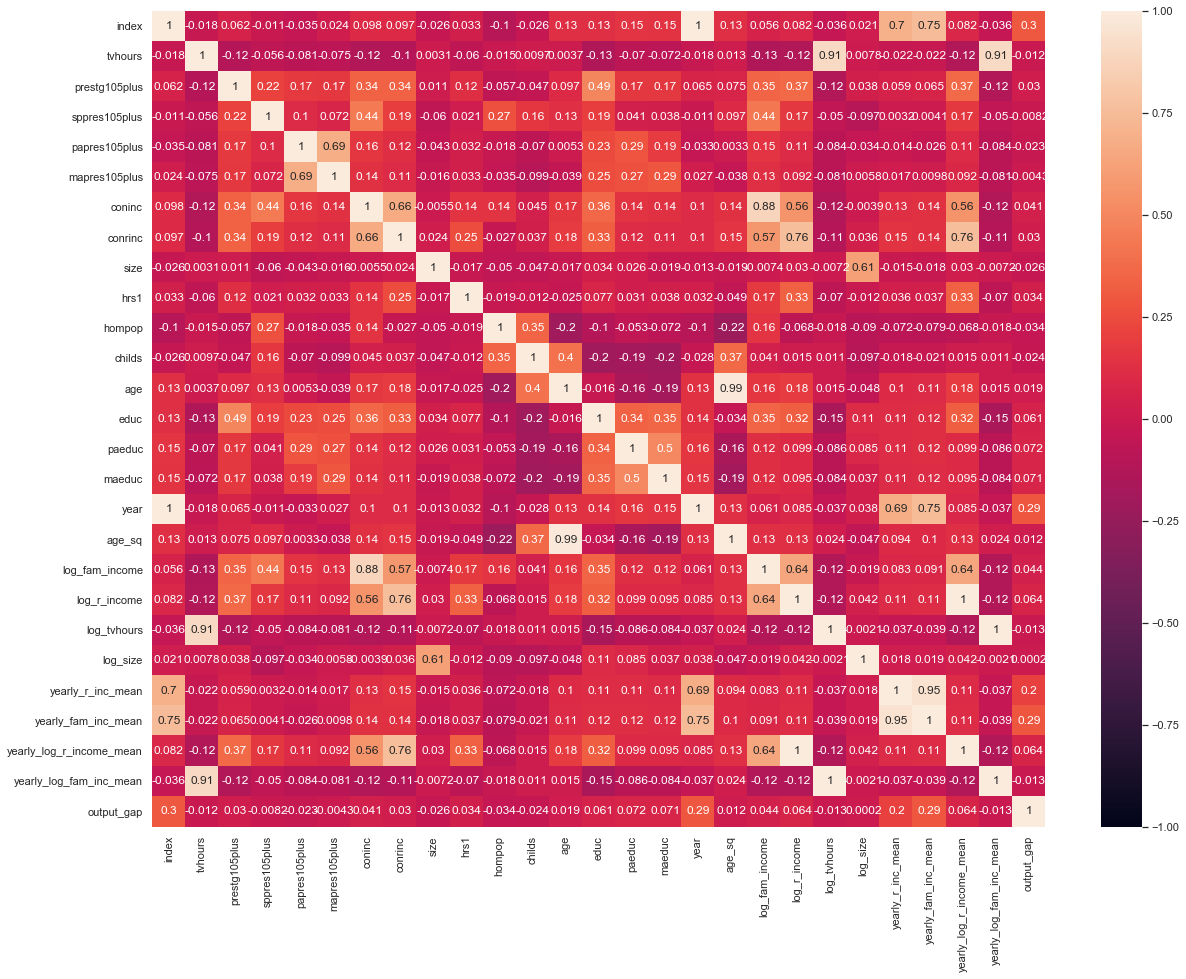

<IPython.core.display.Javascript object>

In [39]:
#look at a selection of data correlations
corrs=happiness_value_labels_clean.corr()
sns.set(rc={'figure.figsize':(20,15)})

sns.heatmap(corrs, vmin=-1, vmax=1, annot=True)


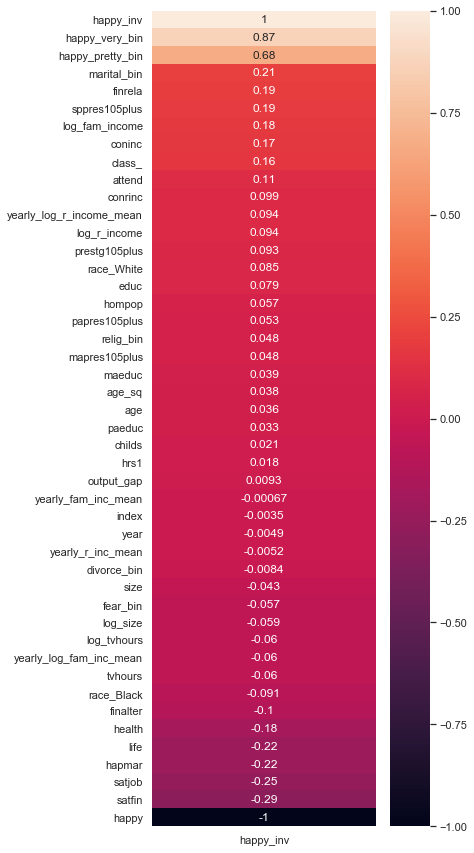

<IPython.core.display.Javascript object>

In [40]:
# looking only at happiness
df_corrs = happiness_clean.corr()[["happy_inv"]].sort_values(
    "happy_inv", ascending=False
)

sns.set(rc={"figure.figsize": (5, 15)})
sns.heatmap(df_corrs, vmin=-1, vmax=1, annot=True)
plt.show()

In [41]:
happiness_clean.marital.value_counts()

Married          16132
Never married     7455
Divorced          4798
Separated         1066
Widowed           1058
Name: marital, dtype: int64

<IPython.core.display.Javascript object>

## Data Inferences:

**First, as a test case, I will try to replicate Kahneman (2010)'s results:**

In [42]:
happiness_clean.head()

,index,satjob,class_,satfin,finalter,finrela,life,partyid,polviews,relig,attend,happy,hapmar,health,fear,tvhours,prestg105plus,sppres105plus,papres105plus,mapres105plus,ballot,coninc,conrinc,size,divorce,spwrksta,marital,wrkstat,hrs1,wrkslf,sex,race,mobile16,parborn,hompop,region,childs,age,educ,paeduc,maeduc,degree,year,age_sq,log_fam_income,log_r_income,log_tvhours,log_size,yearly_r_inc_mean,yearly_fam_inc_mean,yearly_log_r_income_mean,yearly_log_fam_inc_mean,happy_inv,happy_very_bin,happy_pretty_bin,marital_bin,divorce_bin,fear_bin,relig_bin,race_Black,race_White,output_gap
0,9598,2.0,1.0,2.0,2.0,1.0,1.0,Not str republican,Moderate,None,0.0,1.0,0.0,3.0,Yes,2.0,19.0,0.0,0.0,0.0,No Ballot,22573.0,22573.0,8.0,Yes,Working fulltime,Widowed,Working fulltime,53.0,Someone else,Female,Black,Different state,Both in u.s,1.0,Pacific,0.0,39.0,12.0,8.0,0.0,High school,1978.0,1521.0,10.024554,10.024554,1.098612,2.197225,22573.000000,22573.000000,10.024554,1.098612,2.0,0,1,0,1,1,0,1,0,1.165605
1,11668,0.0,1.0,1.0,1.0,1.0,1.0,Strong democrat,Moderate,Protestant,2.0,2.0,0.0,3.0,Yes,2.0,23.0,0.0,0.0,0.0,No Ballot,9892.0,9892.0,497.0,Yes,Working fulltime,Widowed,Working parttime,20.0,Self-employed,Male,White,"Same st,dif city",Both in u.s,1.0,South atlantic,2.0,60.0,12.0,8.0,6.0,High school,1980.0,3600.0,9.199583,9.199583,1.098612,6.210600,32329.341463,51693.430894,9.199583,1.098612,1.0,0,0,0,1,1,1,0,1,-1.871650
2,11634,1.0,2.0,0.0,0.0,2.0,1.0,Not str democrat,Moderate,None,1.0,1.0,0.0,0.0,Yes,4.0,59.0,0.0,0.0,0.0,No Ballot,35722.0,35722.0,201.0,Yes,Working fulltime,Never married,Working fulltime,40.0,Someone else,Male,White,Same city,Both in u.s,2.0,W. nor. central,3.0,34.0,12.0,8.0,12.0,High school,1980.0,1156.0,10.483550,10.483550,1.609438,5.308268,32329.341463,51693.430894,10.483550,1.609438,2.0,0,1,0,1,1,0,0,1,-1.871650
3,11635,0.0,2.0,1.0,0.0,3.0,0.0,Strong democrat,Extrmly conservative,Protestant,8.0,1.0,0.0,2.0,No,4.0,29.0,48.0,58.0,58.0,No Ballot,14289.0,9892.0,201.0,Yes,Working fulltime,Married,Retired,40.0,Someone else,Male,White,"Same st,dif city",Both in u.s,2.0,W. nor. central,3.0,56.0,8.0,8.0,8.0,Lt high school,1980.0,3136.0,9.567315,9.199583,1.609438,5.308268,32329.341463,51693.430894,9.199583,1.609438,2.0,0,1,1,1,0,1,0,1,-1.871650
4,11636,0.0,1.0,0.0,0.0,2.0,0.0,Not str democrat,Moderate,Protestant,3.0,0.0,0.0,1.0,No,1.0,29.0,26.0,58.0,58.0,No Ballot,82436.0,82436.0,201.0,No,Keeping house,Married,Temp not working,52.0,Someone else,Male,White,Same city,Both in u.s,2.0,W. nor. central,1.0,58.0,8.0,7.0,8.0,Lt high school,1980.0,3364.0,11.319790,11.319790,0.693147,5.308268,32329.341463,51693.430894,11.319790,0.693147,3.0,1,1,1,0,0,1,0,1,-1.871650


<IPython.core.display.Javascript object>

In [43]:
X = happiness_clean[
    [
        "year",
        "age",
        "age_sq",
        "log_r_income",
        "marital_bin",
        "educ",
        "race_Black",
        "race_White",
    ]
]
y_v = happiness_clean["happy_very_bin"]
y_p = happiness_clean["happy_pretty_bin"]
y_mn = happiness_clean["happy_inv"]

<IPython.core.display.Javascript object>

In [44]:
print_vif(X)

VIF results
-------------------------------
const           35876.921174
year                1.079049
age                39.094030
age_sq             38.225241
log_r_income        1.260862
marital_bin         1.087631
educ                1.152983
race_Black          2.667440
race_White          2.711104
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

Seems like only age and age squared are related

In [45]:
happiness_value_labels_clean.happy.value_counts()

Pretty happy     17862
Very happy        9451
Not too happy     3196
Name: happy, dtype: int64

<IPython.core.display.Javascript object>

In [46]:
# results predicting being very happy
X_train, X_test, y_train, y_test = train_test_split(
    X, y_v, test_size=0.2, random_state=1
)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)
results = sm.Logit(y_train, X_train_const).fit()
print(results.summary())
y_v_preds = results.predict(X_test_const)
y_v_train_preds = results.predict(X_train_const)

# I'm going to get slightly different answers, but using skikit learn for the confusion matrix is more
# convenient
model = LogisticRegression(C=0.01)
model.fit(X_train, y_train)
y_v_pred = model.predict(X_test)
confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_v_pred),
    index=["Actually Unhappy or Pretty Happy", "Actually Very Happy",],
    columns=["Predicted Unhappy or Pretty Happy", "Predicted Very Happy",],
)
confusion_df.style.background_gradient(axis=None)

Optimization terminated successfully.
         Current function value: 0.598797
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         happy_very_bin   No. Observations:                24407
Model:                          Logit   Df Residuals:                    24398
Method:                           MLE   Df Model:                            8
Date:                Thu, 24 Sep 2020   Pseudo R-squ.:                 0.03320
Time:                        12:02:33   Log-Likelihood:                -14615.
converged:                       True   LL-Null:                       -15117.
Covariance Type:            nonrobust   LLR p-value:                2.498e-211
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.8065      2.675     -1.797      0.072     -10.049       0.436
year             0.0016

,Predicted Unhappy or Pretty Happy,Predicted Very Happy
Actually Unhappy or Pretty Happy,4202,23
Actually Very Happy,1847,30


<IPython.core.display.Javascript object>

In [47]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
print(classification_report(y_test, y_v_pred))

0.6904576555906092
0.6935431006227466
              precision    recall  f1-score   support

           0       0.69      0.99      0.82      4225
           1       0.57      0.02      0.03      1877

    accuracy                           0.69      6102
   macro avg       0.63      0.51      0.42      6102
weighted avg       0.66      0.69      0.58      6102



<IPython.core.display.Javascript object>

In [48]:

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.6923959357587676

<IPython.core.display.Javascript object>

It's basically doing the just as well as predicting 'Not very happy' every time

In [49]:
# results predicting being pretty happy or better
X_train, X_test, y_train, y_test = train_test_split(
    X, y_p, test_size=0.2, random_state=1
)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)
results = sm.Logit(y_train, X_train_const).fit()
print(results.summary())
y_p_preds = results.predict(X_test_const)
y_p_train_preds = results.predict(X_train_const)

# I'm going to get slightly different answers, but using skikit learn for the confusion matrix is more
# convenient
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_p_pred = model.predict(X_test)
confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_p_pred),
    index=["Actually Unhappy", "Actually Pretty or Very Happy",],
    columns=["Predicted Unhappy", "Predicted Pretty or Very Happy",],
)
confusion_df.style.background_gradient(axis=None)

Optimization terminated successfully.
         Current function value: 0.314728
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       happy_pretty_bin   No. Observations:                24407
Model:                          Logit   Df Residuals:                    24398
Method:                           MLE   Df Model:                            8
Date:                Thu, 24 Sep 2020   Pseudo R-squ.:                 0.05123
Time:                        12:02:33   Log-Likelihood:                -7681.6
converged:                       True   LL-Null:                       -8096.3
Covariance Type:            nonrobust   LLR p-value:                9.002e-174
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.4417      4.046      0.356      0.722      -6.489       9.372
year            -0.0004

,Predicted Unhappy,Predicted Pretty or Very Happy
Actually Unhappy,0,681
Actually Pretty or Very Happy,0,5421


<IPython.core.display.Javascript object>

This is really just a terrible estimator. Conclusion: The main weakness of this model, recall, is exactly what you would want to do well: it's not much use to say that the people who you predict to be happy are happy, but that you have an accurate idea of how many people are happy and so that you can design policies to improve their lives.

In [50]:
print(classification_report(y_test, y_v_pred))
y_v_pred

              precision    recall  f1-score   support

           0       0.11      1.00      0.20       681
           1       0.98      0.01      0.02      5421

    accuracy                           0.12      6102
   macro avg       0.55      0.50      0.11      6102
weighted avg       0.88      0.12      0.04      6102



array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

<IPython.core.display.Javascript object>

It would be better to downsample The 1 classification. Try again with a "balanced" specification:

In [51]:
# predicting 'very or pretty happy'
model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)
y_p_pred = model.predict(X_test)
confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_p_pred),
    index=["Actually Unhappy", "Actually Very or Pretty Happy",],
    columns=["Predicted Unhappy", "Predicted Very or Pretty Happy",],
)
confusion_df.style.background_gradient(axis=None)

,Predicted Unhappy,Predicted Very or Pretty Happy
Actually Unhappy,430,251
Actually Very or Pretty Happy,2100,3321


<IPython.core.display.Javascript object>

In [52]:
print(classification_report(y_test, y_v_pred))

              precision    recall  f1-score   support

           0       0.11      1.00      0.20       681
           1       0.98      0.01      0.02      5421

    accuracy                           0.12      6102
   macro avg       0.55      0.50      0.11      6102
weighted avg       0.88      0.12      0.04      6102



<IPython.core.display.Javascript object>

In [53]:
# Multinomial regression:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_mn, test_size=0.2, random_state=1
)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)
results = sm.MNLogit(y_train, X_train_const).fit()
print(results.summary())
y_mn_preds = results.predict(X_test_const)
y_mn_train_preds = results.predict(X_train_const)

# I'm going to get slightly different answers, but using skikit learn for the confusion matrix is more
# convenient
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_mn_pred = model.predict(X_test)
confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_mn_pred),
    index=["Actually Unhappy", "Actually Pretty Happy", "Actually Very Happy"],
    columns=["Predicted Unhappy", "Predicted Pretty Happy", "Predicted Very Happy"],
)
confusion_df.style.background_gradient(axis=None)

Optimization terminated successfully.
         Current function value: 0.878574
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:              happy_inv   No. Observations:                24407
Model:                        MNLogit   Df Residuals:                    24389
Method:                           MLE   Df Model:                           16
Date:                Thu, 24 Sep 2020   Pseudo R-squ.:                 0.03473
Time:                        12:02:34   Log-Likelihood:                -21443.
converged:                       True   LL-Null:                       -22215.
Covariance Type:            nonrobust   LLR p-value:                     0.000
 happy_inv=2       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.3450      4.132      0.568      0.570      -5.753      10.443
year            -0.0010

,Predicted Unhappy,Predicted Pretty Happy,Predicted Very Happy
Actually Unhappy,0,678,3
Actually Pretty Happy,1,3504,39
Actually Very Happy,0,1830,47


<IPython.core.display.Javascript object>

We can see that log of income does indeed matter, at least for these terrible estimators. And yet...

Conclusion: it seems like, though Kahneman doesn't supply his recall scores, an uses a slightly different estimating method, he probably doesn't have the most powerful model. Can we improve on it?

From here, I will focus on predicting y_v, or a binary variable where 1='very happy', since this is the most balanced. 

In [54]:
happiness_clean.head()

,index,satjob,class_,satfin,finalter,finrela,life,partyid,polviews,relig,attend,happy,hapmar,health,fear,tvhours,prestg105plus,sppres105plus,papres105plus,mapres105plus,ballot,coninc,conrinc,size,divorce,spwrksta,marital,wrkstat,hrs1,wrkslf,sex,race,mobile16,parborn,hompop,region,childs,age,educ,paeduc,maeduc,degree,year,age_sq,log_fam_income,log_r_income,log_tvhours,log_size,yearly_r_inc_mean,yearly_fam_inc_mean,yearly_log_r_income_mean,yearly_log_fam_inc_mean,happy_inv,happy_very_bin,happy_pretty_bin,marital_bin,divorce_bin,fear_bin,relig_bin,race_Black,race_White,output_gap
0,9598,2.0,1.0,2.0,2.0,1.0,1.0,Not str republican,Moderate,None,0.0,1.0,0.0,3.0,Yes,2.0,19.0,0.0,0.0,0.0,No Ballot,22573.0,22573.0,8.0,Yes,Working fulltime,Widowed,Working fulltime,53.0,Someone else,Female,Black,Different state,Both in u.s,1.0,Pacific,0.0,39.0,12.0,8.0,0.0,High school,1978.0,1521.0,10.024554,10.024554,1.098612,2.197225,22573.000000,22573.000000,10.024554,1.098612,2.0,0,1,0,1,1,0,1,0,1.165605
1,11668,0.0,1.0,1.0,1.0,1.0,1.0,Strong democrat,Moderate,Protestant,2.0,2.0,0.0,3.0,Yes,2.0,23.0,0.0,0.0,0.0,No Ballot,9892.0,9892.0,497.0,Yes,Working fulltime,Widowed,Working parttime,20.0,Self-employed,Male,White,"Same st,dif city",Both in u.s,1.0,South atlantic,2.0,60.0,12.0,8.0,6.0,High school,1980.0,3600.0,9.199583,9.199583,1.098612,6.210600,32329.341463,51693.430894,9.199583,1.098612,1.0,0,0,0,1,1,1,0,1,-1.871650
2,11634,1.0,2.0,0.0,0.0,2.0,1.0,Not str democrat,Moderate,None,1.0,1.0,0.0,0.0,Yes,4.0,59.0,0.0,0.0,0.0,No Ballot,35722.0,35722.0,201.0,Yes,Working fulltime,Never married,Working fulltime,40.0,Someone else,Male,White,Same city,Both in u.s,2.0,W. nor. central,3.0,34.0,12.0,8.0,12.0,High school,1980.0,1156.0,10.483550,10.483550,1.609438,5.308268,32329.341463,51693.430894,10.483550,1.609438,2.0,0,1,0,1,1,0,0,1,-1.871650
3,11635,0.0,2.0,1.0,0.0,3.0,0.0,Strong democrat,Extrmly conservative,Protestant,8.0,1.0,0.0,2.0,No,4.0,29.0,48.0,58.0,58.0,No Ballot,14289.0,9892.0,201.0,Yes,Working fulltime,Married,Retired,40.0,Someone else,Male,White,"Same st,dif city",Both in u.s,2.0,W. nor. central,3.0,56.0,8.0,8.0,8.0,Lt high school,1980.0,3136.0,9.567315,9.199583,1.609438,5.308268,32329.341463,51693.430894,9.199583,1.609438,2.0,0,1,1,1,0,1,0,1,-1.871650
4,11636,0.0,1.0,0.0,0.0,2.0,0.0,Not str democrat,Moderate,Protestant,3.0,0.0,0.0,1.0,No,1.0,29.0,26.0,58.0,58.0,No Ballot,82436.0,82436.0,201.0,No,Keeping house,Married,Temp not working,52.0,Someone else,Male,White,Same city,Both in u.s,2.0,W. nor. central,1.0,58.0,8.0,7.0,8.0,Lt high school,1980.0,3364.0,11.319790,11.319790,0.693147,5.308268,32329.341463,51693.430894,11.319790,0.693147,3.0,1,1,1,0,0,1,0,1,-1.871650


<IPython.core.display.Javascript object>

 columns to drop due to duplication or non-usefulness for classification: race_Black,race_White, ballot, index, marital, degree, polviews

In [56]:
X = happiness_clean.drop(columns=['race_Black', 'race_White', 
                                  'ballot', 'index', 'marital', 'degree',
                                 'happy_inv','happy_very_bin','happy_pretty_bin', 
                                  'divorce', 'fear', 'relig', 'happy','polviews'])
y_v = happiness_clean["happy_very_bin"]

#want train test split with y_v=1 when happy=='very happy'

X_train, X_test, y_train, y_test = train_test_split(
    X, y_v, test_size=0.2, random_state=1
)


<IPython.core.display.Javascript object>

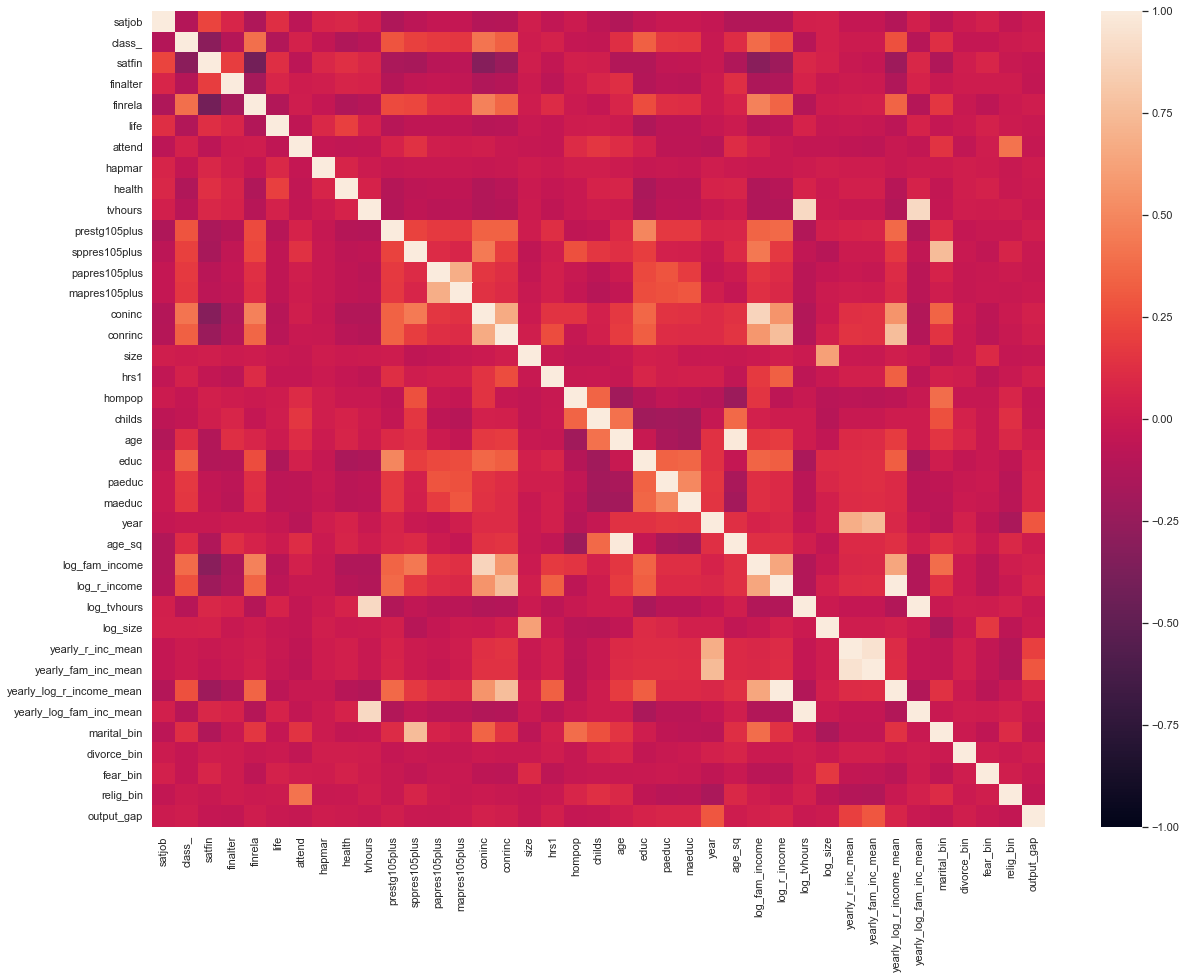

<IPython.core.display.Javascript object>

In [57]:
# print_vif(X)
corrsX=X.corr()
sns.set(rc={'figure.figsize':(20,15)})

sns.heatmap(corrsX, vmin=-1, vmax=1, annot=False)


**Second, try XGBoost classifier, for an initial look at what might be a good way to split up the data, as well as getting feature importances.**

In [58]:



# column datatypes
num_cols = numeric_cols

bin_cols = ['marital_bin','divorce_bin','fear_bin','relig_bin']

cat_cols = ['partyid', 'spwrksta',
       'wrkstat', 'wrkslf', 'sex', 
            'race', 'mobile16', 'parborn',
       'region',]


preprocessing = ColumnTransformer([
    ('leaveoneoutencoder', LeaveOneOutEncoder(), cat_cols),

    # Scale numeric columns 
    ('scaler', StandardScaler(), num_cols)
    
    # bin_cols we'll leave untouch
], remainder='passthrough')

n_trees = 100
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ("xgb", XGBClassifier(n_estimators = n_trees, learning_rate=2 / n_trees))
])


grid = {
    "xgb__subsample": [0.5, 0.75, 1.0],
    "xgb__max_features": [0.5, 0.75, 1.0],
    "xgb__max_depth": [2, 3, 4, 5],
}

pipeline_cv = GridSearchCV(pipeline, grid, cv=2, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

print(pipeline_cv.score(X_train, y_train))
print(pipeline_cv.score(X_test, y_test))



[12:03:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.6896791903961978
0.6923959357587676


<IPython.core.display.Javascript object>

.69 Accuracy score? This looks farmiliar, being the same score from only choosing the most frequent class.

In [59]:
print("Best params:")
print(pipeline_cv.best_params_)

print(f"\ntrain score: {pipeline_cv.score(X_train, y_train):.3f}")
print(f"test score: {pipeline_cv.score(X_test, y_test):.3f}\n")

y_pred = pipeline_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best params:
{'xgb__max_depth': 2, 'xgb__max_features': 0.5, 'xgb__subsample': 0.5}

train score: 0.690
test score: 0.692

[[4225    0]
 [1877    0]]
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      4225
           1       0.00      0.00      0.00      1877

    accuracy                           0.69      6102
   macro avg       0.35      0.50      0.41      6102
weighted avg       0.48      0.69      0.57      6102



/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>

In [60]:
importances = pipeline_cv.best_estimator_["xgb"].feature_importances_
im_df = pd.DataFrame({"feat": X_train.columns, "importance": importances})
im_df.sort_values("importance", ascending=False)

,feat,importance
3,finalter,0.508814
7,attend,0.124538
4,finrela,0.123148
5,life,0.093393
2,satfin,0.078034
6,partyid,0.072073
0,satjob,0.000000
37,log_tvhours,0.000000
29,age,0.000000
30,educ,0.000000


<IPython.core.display.Javascript object>

In [61]:
happiness_clean.head()

,index,satjob,class_,satfin,finalter,finrela,life,partyid,polviews,relig,attend,happy,hapmar,health,fear,tvhours,prestg105plus,sppres105plus,papres105plus,mapres105plus,ballot,coninc,conrinc,size,divorce,spwrksta,marital,wrkstat,hrs1,wrkslf,sex,race,mobile16,parborn,hompop,region,childs,age,educ,paeduc,maeduc,degree,year,age_sq,log_fam_income,log_r_income,log_tvhours,log_size,yearly_r_inc_mean,yearly_fam_inc_mean,yearly_log_r_income_mean,yearly_log_fam_inc_mean,happy_inv,happy_very_bin,happy_pretty_bin,marital_bin,divorce_bin,fear_bin,relig_bin,race_Black,race_White,output_gap
0,9598,2.0,1.0,2.0,2.0,1.0,1.0,Not str republican,Moderate,None,0.0,1.0,0.0,3.0,Yes,2.0,19.0,0.0,0.0,0.0,No Ballot,22573.0,22573.0,8.0,Yes,Working fulltime,Widowed,Working fulltime,53.0,Someone else,Female,Black,Different state,Both in u.s,1.0,Pacific,0.0,39.0,12.0,8.0,0.0,High school,1978.0,1521.0,10.024554,10.024554,1.098612,2.197225,22573.000000,22573.000000,10.024554,1.098612,2.0,0,1,0,1,1,0,1,0,1.165605
1,11668,0.0,1.0,1.0,1.0,1.0,1.0,Strong democrat,Moderate,Protestant,2.0,2.0,0.0,3.0,Yes,2.0,23.0,0.0,0.0,0.0,No Ballot,9892.0,9892.0,497.0,Yes,Working fulltime,Widowed,Working parttime,20.0,Self-employed,Male,White,"Same st,dif city",Both in u.s,1.0,South atlantic,2.0,60.0,12.0,8.0,6.0,High school,1980.0,3600.0,9.199583,9.199583,1.098612,6.210600,32329.341463,51693.430894,9.199583,1.098612,1.0,0,0,0,1,1,1,0,1,-1.871650
2,11634,1.0,2.0,0.0,0.0,2.0,1.0,Not str democrat,Moderate,None,1.0,1.0,0.0,0.0,Yes,4.0,59.0,0.0,0.0,0.0,No Ballot,35722.0,35722.0,201.0,Yes,Working fulltime,Never married,Working fulltime,40.0,Someone else,Male,White,Same city,Both in u.s,2.0,W. nor. central,3.0,34.0,12.0,8.0,12.0,High school,1980.0,1156.0,10.483550,10.483550,1.609438,5.308268,32329.341463,51693.430894,10.483550,1.609438,2.0,0,1,0,1,1,0,0,1,-1.871650
3,11635,0.0,2.0,1.0,0.0,3.0,0.0,Strong democrat,Extrmly conservative,Protestant,8.0,1.0,0.0,2.0,No,4.0,29.0,48.0,58.0,58.0,No Ballot,14289.0,9892.0,201.0,Yes,Working fulltime,Married,Retired,40.0,Someone else,Male,White,"Same st,dif city",Both in u.s,2.0,W. nor. central,3.0,56.0,8.0,8.0,8.0,Lt high school,1980.0,3136.0,9.567315,9.199583,1.609438,5.308268,32329.341463,51693.430894,9.199583,1.609438,2.0,0,1,1,1,0,1,0,1,-1.871650
4,11636,0.0,1.0,0.0,0.0,2.0,0.0,Not str democrat,Moderate,Protestant,3.0,0.0,0.0,1.0,No,1.0,29.0,26.0,58.0,58.0,No Ballot,82436.0,82436.0,201.0,No,Keeping house,Married,Temp not working,52.0,Someone else,Male,White,Same city,Both in u.s,2.0,W. nor. central,1.0,58.0,8.0,7.0,8.0,Lt high school,1980.0,3364.0,11.319790,11.319790,0.693147,5.308268,32329.341463,51693.430894,11.319790,0.693147,3.0,1,1,1,0,0,1,0,1,-1.871650


<IPython.core.display.Javascript object>

**Now, I'll try it one more time with only the variables of any importance, plus the income variable, as well as adjusting the grid:**

In [62]:
num_cols = ['finrela','attend','life','finalter']


cat_cols = ['polviews',]

preprocessing = ColumnTransformer([
    ('leaveoneoutencoder', LeaveOneOutEncoder(), cat_cols),

    # Scale numeric columns 
    ('scaler', StandardScaler(), num_cols)
    
    # bin_cols we'll leave untouch
], remainder='passthrough')

n_trees = 100
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ("xgb", XGBClassifier(n_estimators = n_trees, learning_rate=2 / n_trees)),
])



X=happiness_clean[['finrela','attend','life','finalter','polviews']]
y_v=happiness_clean['happy_very_bin']
X_train, X_test, y_train, y_test = train_test_split(
    X, y_v, test_size=0.2, random_state=1
)

grid = {
    "xgb__subsample": [.2,0.5],
    "xgb__max_features": [.2, 0.5],
    "xgb__max_depth": [1,2,],
}

pipeline_cv = GridSearchCV(pipeline, grid, cv=2, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

print(pipeline_cv.score(X_train, y_train))
print(pipeline_cv.score(X_test, y_test))


[12:04:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.6896791903961978
0.6923959357587676


<IPython.core.display.Javascript object>

No improvement on accuracy

In [63]:
importances = pipeline_cv.best_estimator_["xgb"].feature_importances_
im_df = pd.DataFrame({"feat": X_train.columns, "importance": importances})
im_df.sort_values("importance", ascending=False)

,feat,importance
0,finrela,0.570448
3,finalter,0.429552
1,attend,0.000000
2,life,0.000000
4,polviews,0.000000


<IPython.core.display.Javascript object>

In [64]:
#I would take out this for the final product to show employers. 
#Keeping it around for trying to get it to work later
# income_happiness = pd.crosstab(
#     happiness_value_labels_clean.conrinc,
#     happiness_value_labels_clean.happy,
#     normalize="index",
# )
# year_happiness[1978:]

<IPython.core.display.Javascript object>

In [65]:
# happiness_value_labels_clean.info()

<IPython.core.display.Javascript object>

Finally, try SVC with the most important features

In [ ]:
num_cols = ['finrela','attend']


cat_cols = ['polviews','life','finalter']

preprocessing = ColumnTransformer([
    ('OneHotEncoder', OneHotEncoder(), cat_cols),    
    # Scale numeric columns 
    ('scaler', StandardScaler(), num_cols)
    
    # bin_cols we'll leave untouch
], remainder='passthrough')

#n_trees = 100
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('svc', SVC(C=1000, kernel='rbf'))
])



X=happiness_clean[['finrela','attend','life','finalter','polviews']]
y_v=happiness_clean['happy_very_bin']
X_train, X_test, y_train, y_test = train_test_split(
    X, y_v, test_size=0.2, random_state=1
)

grid = {
    #'svc__kernel':['rbf', 'linear'],
    'svc__degree':[2,3,4]
}

pipeline_cv = GridSearchCV(pipeline, grid, cv=2, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

print(pipeline_cv.score(X_train, y_train))
print(pipeline_cv.score(X_test, y_test))


In [ ]:
print("Best params:")
print(pipeline_cv.best_params_)

print(f"\ntrain score: {pipeline_cv.score(X_train, y_train):.3f}")
print(f"test score: {pipeline_cv.score(X_test, y_test):.3f}\n")

y_pred = pipeline_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))